# AUTHORS

### Abhimanyu Borthakur (406530322)

### Lorenzo Bolls (505997448)

### Arthur Baghdasian (006001418)

# Part 1

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans,  AgglomerativeClustering, DBSCAN
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, v_measure_score
from sklearn.metrics import confusion_matrix 
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import TruncatedSVD, NMF
from plotmat import plot_mat
from matplotlib import pyplot as plt
import numpy as np
import random
import pandas as pd
import umap.umap_ as umap
import hdbscan
import joblib 
np.random.seed(0)
random.seed(0)

# Question 1

### As we can see below the shape of the TFIDF matrix is 7882 x 23522

In [2]:
categories = ['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware','rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
dataset = fetch_20newsgroups(subset = 'all', categories = categories,shuffle = True, random_state = 0,remove=('headers','footers'))
vectorizer = CountVectorizer(stop_words='english',min_df=3)
tfidf_transformer = TfidfTransformer()
data_vec = vectorizer.fit_transform(dataset.data)
features = tfidf_transformer.fit_transform(data_vec)

ground_truth = []
for label in dataset.target:
    if label < 4:
        ground_truth.append(0)
    else:
        ground_truth.append(1)
        
print('Shape of TF-IDF matrix: ',features.shape)

Shape of TF-IDF matrix:  (7882, 23522)


# Question 2

### Below is the plot of the contingency matrix.

### Additionally, the contingency matrix’s dimensions depend on the number of clusters and the number of classes, which may not be equal. Therefore, it can be rectangular when these numbers differ.

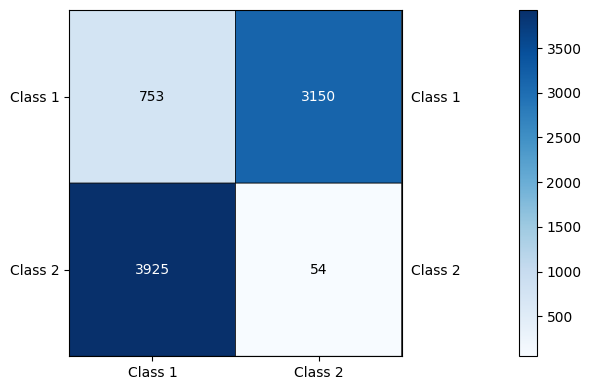

In [3]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=5000, n_init=200, random_state=0)
kmeans.fit(features)
plot_mat(contingency_matrix(ground_truth,kmeans.labels_),size=(6,4),xticklabels = ['Class 1','Class 2'],yticklabels = ['Class 1','Class 2'],pic_fname = 'Q2.png')

# Question 3

### The 5 measures are reported below:

In [5]:
print("Homogeneity: %0.3f" % homogeneity_score(ground_truth, kmeans.labels_))
print("Completeness: %0.3f" % completeness_score(ground_truth, kmeans.labels_))
print("V-measure: %0.3f" % v_measure_score(ground_truth, kmeans.labels_))
print("Adjusted Rand-Index: %.3f"% adjusted_rand_score(ground_truth, kmeans.labels_))
print("Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(ground_truth, kmeans.labels_))

Homogeneity: 0.572
Completeness: 0.587
V-measure: 0.579
Adjusted Rand-Index: 0.632
Adjusted Mutual Information Score: 0.579


# Question 4

### The plot is reported below - as 'r' increases, the variance retention ratio increases.

In [13]:
svd = TruncatedSVD(n_components=1000, random_state=0)
LSI = svd.fit_transform(features)

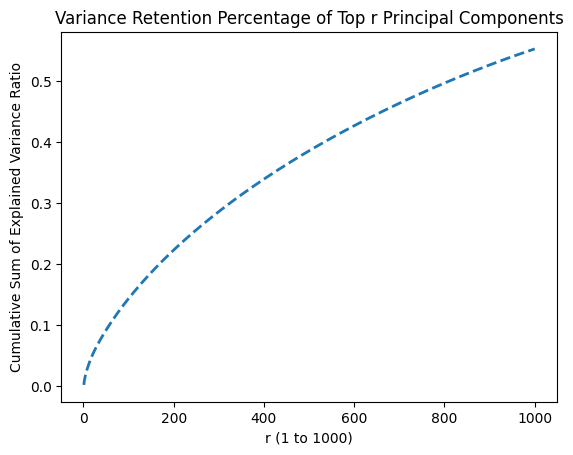

In [14]:
plt.plot(np.linspace(1,1000,1000),np.cumsum(svd.explained_variance_ratio_),lw=2,linestyle='--')
plt.title('Variance Retention Percentage of Top r Principal Components')
plt.ylabel('Cumulative Sum of Explained Variance Ratio')
plt.xlabel('r (1 to 1000)')
plt.savefig('Q4.png',dpi=300,bbox_inches='tight')
plt.show()

# Question 5

### First let us compute all the scores for all the values of r.

In [15]:
svd_hs = []
svd_cs = []
svd_vs = []
svd_ari = []
svd_ms = []
nmf_hs = []
nmf_cs = []
nmf_vs = []
nmf_ari = []
nmf_ms = []

r = [1,2,3,4,5,6,7,8,9,10,20,50,100,300]

for i in range(len(r)):
    print('Testing SVD for r = ',r[i])
    svd = TruncatedSVD(n_components=r[i], random_state=0)
    svd_km = svd.fit_transform(features)
    kmean_svd = kmeans.fit(svd_km)
    svd_hs.append(homogeneity_score(ground_truth, kmean_svd.labels_))
    svd_cs.append(completeness_score(ground_truth, kmean_svd.labels_))
    svd_vs.append(v_measure_score(ground_truth, kmean_svd.labels_))
    svd_ari.append(adjusted_rand_score(ground_truth, kmean_svd.labels_))
    svd_ms.append(adjusted_mutual_info_score(ground_truth, kmean_svd.labels_))    
    print('Testing NMF for r = ',r[i])
    nmf = NMF(n_components=r[i], init='random', random_state=0, max_iter=400)
    nmf_km = nmf.fit_transform(features)
    kmean_nmf = kmeans.fit(nmf_km)
    nmf_hs.append(homogeneity_score(ground_truth, kmean_nmf.labels_))
    nmf_cs.append(completeness_score(ground_truth, kmean_nmf.labels_))
    nmf_vs.append(v_measure_score(ground_truth, kmean_nmf.labels_))
    nmf_ari.append(adjusted_rand_score(ground_truth, kmean_nmf.labels_))
    nmf_ms.append(adjusted_mutual_info_score(ground_truth, kmean_nmf.labels_))

print('Done testing.')

Testing SVD for r =  1
Testing NMF for r =  1
Testing SVD for r =  2
Testing NMF for r =  2
Testing SVD for r =  3
Testing NMF for r =  3
Testing SVD for r =  4
Testing NMF for r =  4
Testing SVD for r =  5
Testing NMF for r =  5
Testing SVD for r =  6
Testing NMF for r =  6
Testing SVD for r =  7
Testing NMF for r =  7
Testing SVD for r =  8
Testing NMF for r =  8
Testing SVD for r =  9
Testing NMF for r =  9
Testing SVD for r =  10
Testing NMF for r =  10
Testing SVD for r =  20
Testing NMF for r =  20
Testing SVD for r =  50
Testing NMF for r =  50
Testing SVD for r =  100
Testing NMF for r =  100
Testing SVD for r =  300
Testing NMF for r =  300
Done testing.


### Now let us compare the scores of NMF and SVD(for each value of 'r') with those in Question 3

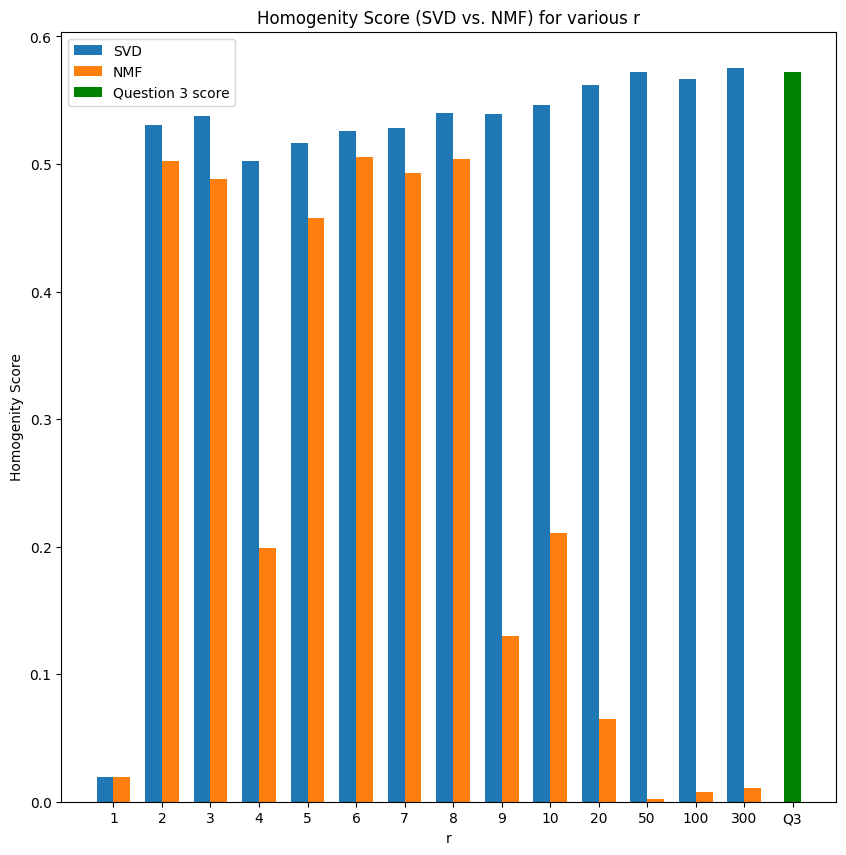

In [31]:
width = 0.35 
fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_hs, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_hs, width, label='NMF')
rects3 = ax.bar(len(r), 0.572, width, label='Question 3 score', color='green')
ax.set_ylabel('Homogenity Score')
ax.set_title('Homogenity Score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r) + 1))
ax.set_xticklabels(list(r) + ['Q3'])  
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q51.png', dpi=300, bbox_inches='tight')
plt.show()


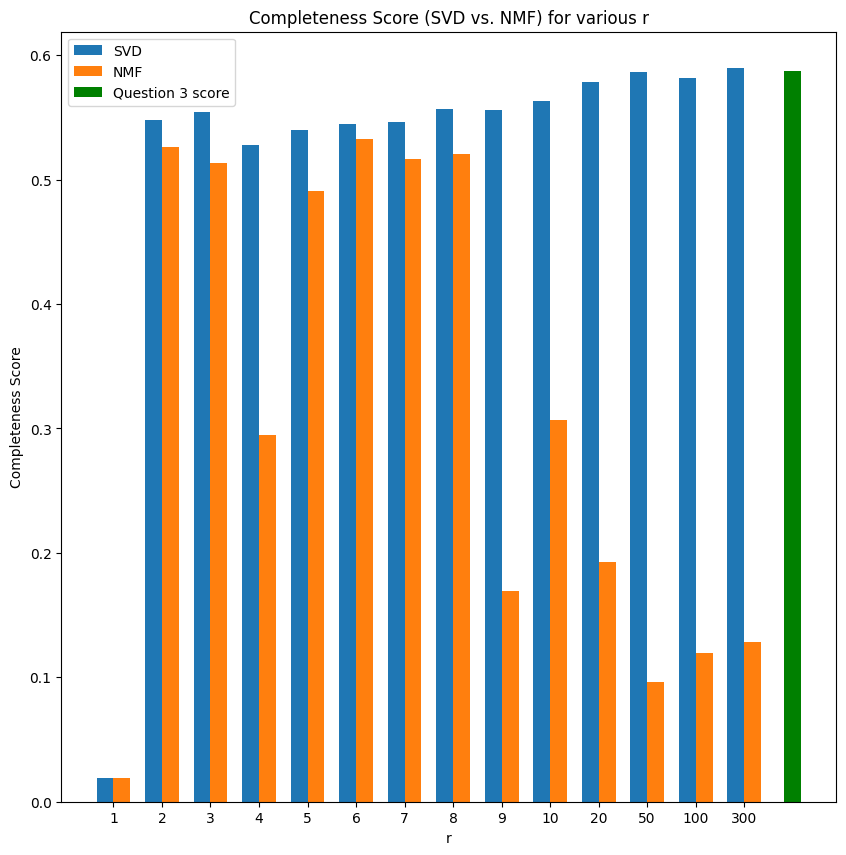

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_cs, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_cs, width, label='NMF')
rects3 = ax.bar(len(r), 0.587, width, label='Question 3 score', color='green')
ax.set_ylabel('Completeness Score')
ax.set_title('Completeness Score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q52.png',dpi=300,bbox_inches='tight')
plt.show()

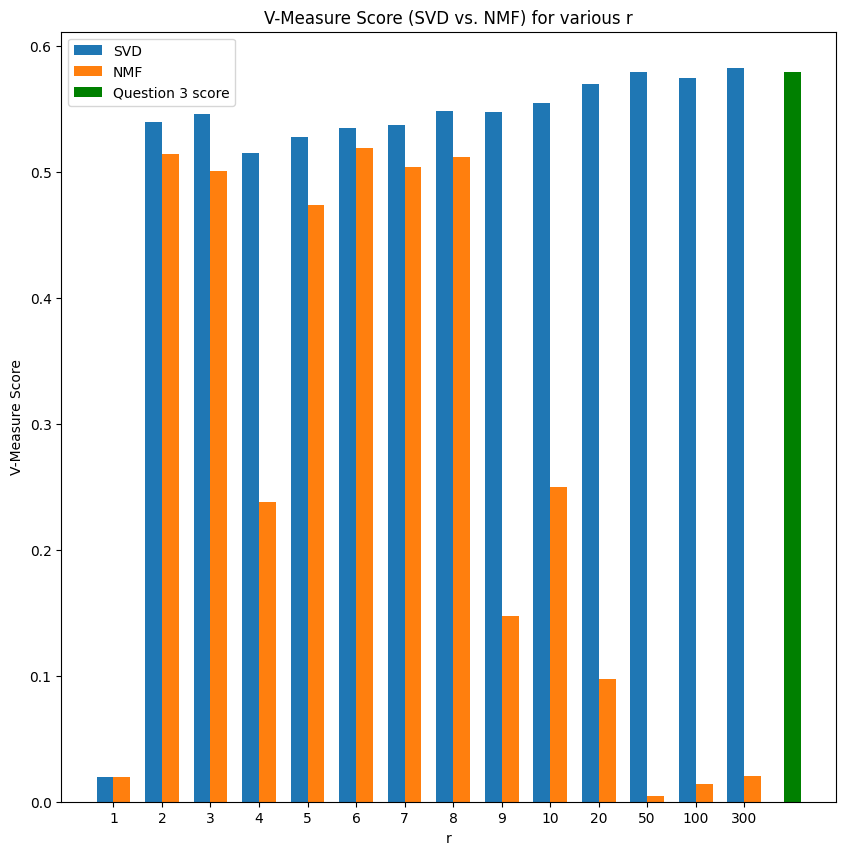

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_vs, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_vs, width, label='NMF')
rects3 = ax.bar(len(r), 0.579, width, label='Question 3 score', color='green')
ax.set_ylabel('V-Measure Score')
ax.set_title('V-Measure Score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q53.png',dpi=300,bbox_inches='tight')
plt.show()

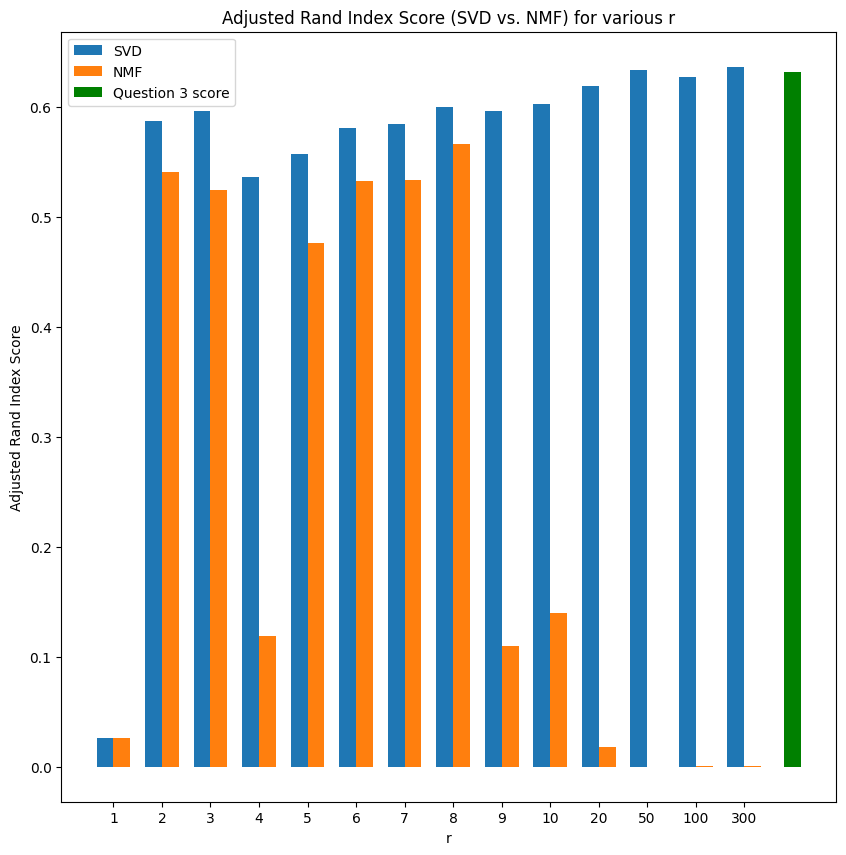

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_ari, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_ari, width, label='NMF')
rects3 = ax.bar(len(r), 0.632, width, label='Question 3 score', color='green')
ax.set_ylabel('Adjusted Rand Index Score')
ax.set_title('Adjusted Rand Index Score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q54.png',dpi=300,bbox_inches='tight')
plt.show()

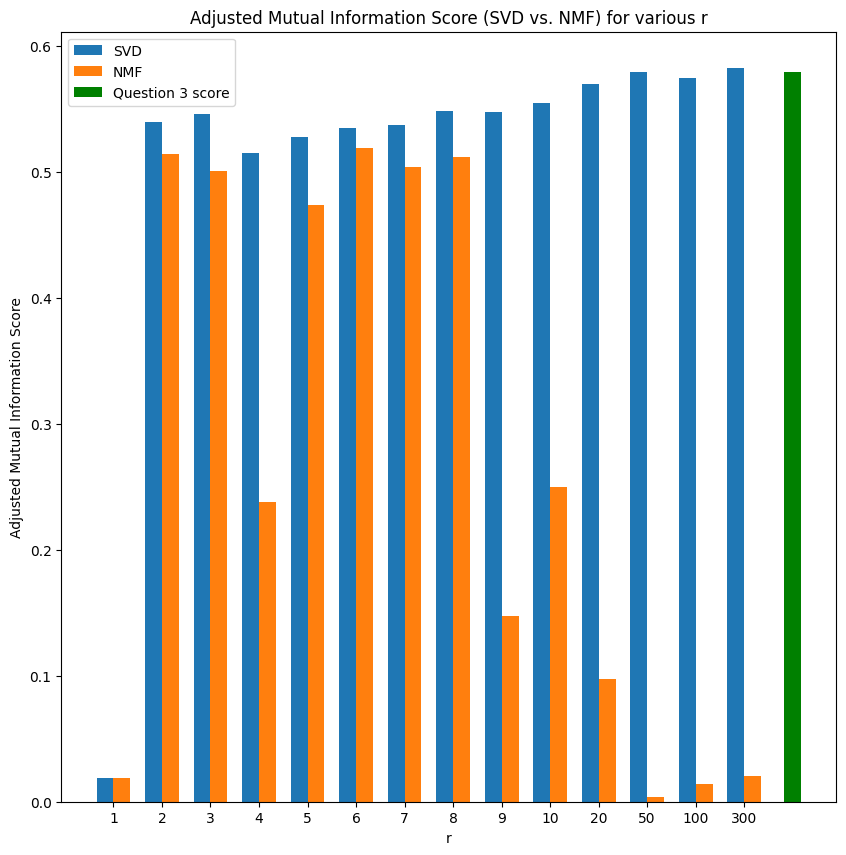

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_ms, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_ms, width, label='NMF')
rects3 = ax.bar(len(r), 0.579, width, label='Question 3 score', color='green')
ax.set_ylabel('Adjusted Mutual Information Score')
ax.set_title('Adjusted Mutual Information Score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q55.png',dpi=300,bbox_inches='tight')
plt.show()

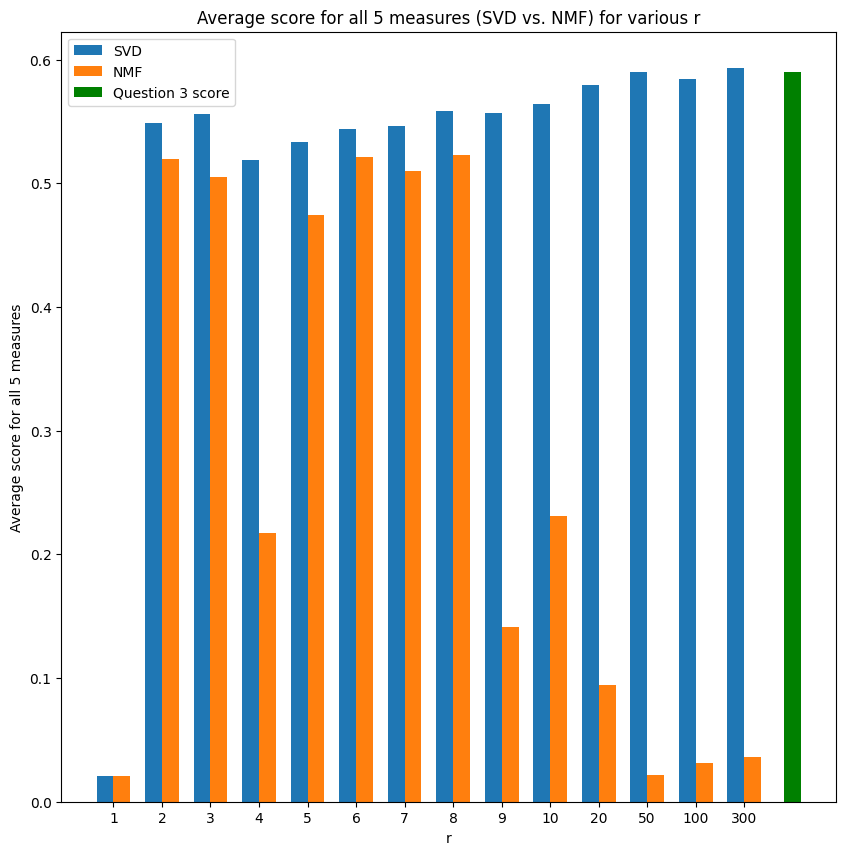

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(np.arange(len(r)) - width/2, [y/5 for y in [sum(x) for x in zip(svd_hs, svd_cs, svd_vs, svd_ari, svd_ms)]], width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, [y/5 for y in [sum(x) for x in zip(nmf_hs, nmf_cs, nmf_vs, nmf_ari, nmf_ms)]], width, label='NMF')
rects3 = ax.bar(len(r), (0.572+0.587+0.579+0.632+0.579)/5, width, label='Question 3 score', color='green')
ax.set_ylabel('Average score for all 5 measures')
ax.set_title('Average score for all 5 measures (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q56.png',dpi=300,bbox_inches='tight')
plt.show()

### Thus, we need to choose a value of r that contains sufficient information but is also not too large as K-means does not perform well in high-dimensions. For SVD, we can see that the clustering performance does not increase significantly after r = 50. As a result, a good choice for r for SVD is 50, while a good choice for r for NMF is 2.


# Question 6


### From the figures, we see that as r increases, the clustering metrics do not necessarily increase in a uniform manner. While a larger r in principle preserves more semantic and complex structural information—potentially yielding better separation and compactness—this also corresponds to a higher-dimensional, noisier feature matrix that undermines K-means performance. In high-dimensional settings, the rapid growth in dimensional volume makes data points equidistant, rendering it difficult for the algorithm to place centroids with sufficient separation (especially when inertia is not normalized). This effect is particularly visible for NMF, whose metrics initially improve but then rapidly decline. Moreover, NMF is more volatile than SVD, which stabilizes once r exceeds 2. Because NMF enforces nonnegative entries in the factorized matrices, whereas SVD does not impose such constraints, SVD is better able to capture high-dimensional representations with fewer losses. In contrast, NMF tends to lose effectiveness as r grows. Additionally, SVD is more deterministic and employs a geometric, hierarchical ordering of features, unlike NMF. Consequently, increasing r with SVD does not substantially degrade clustering performance; from a K-means standpoint, at higher r, SVD neither adds nor removes crucial semantic information. Hence, results remain fairly consistent for r values from 2 through 300, while NMF’s performance starts to fall off noticeably beyond r = 2. Lastly, SVD tends to produce a unique solution, whereas NMF is non-unique and more reliant on initialization, offering no guarantee of converging to the same factorization on each run.




# Question 7

### From these bar charts, the green bar labeled “Question 3 score” is generally on par with—or slightly higher than—most of the SVD or NMF bars across the various values of *r*. In particular:

- **SVD** sometimes meets or slightly exceeds the Question 3 score at certain higher *r* values (e.g. around *r* = 50-300)
- **NMF** frequently falls off more sharply as *r* grows and never outperforms the Question 3 score.

Averaging over all plotted *r* values, neither SVD nor NMF consistently surpasses the Question 3 score. In other words, the results from Question 3 are at least as good as (and often better than) the average outcomes shown here.


# Question 8

### The visualisations are reported below:

In [41]:
svd = TruncatedSVD(n_components=20, random_state=0)
svd_km = svd.fit_transform(features)
y_svd = kmeans.fit_predict(svd_km)
nmf = NMF(n_components=2, init='random', random_state=0, max_iter=400)
nmf_km = nmf.fit_transform(features)
nmf_svd = kmeans.fit_predict(nmf_km)

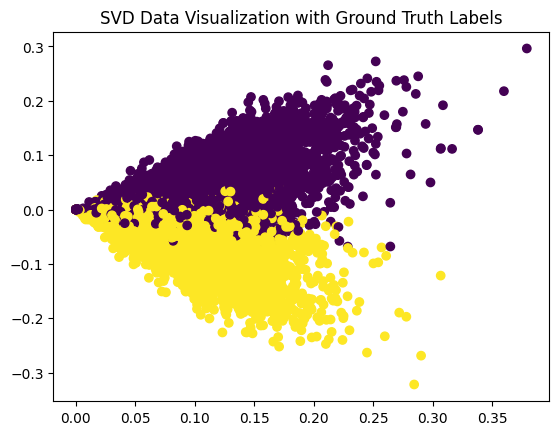

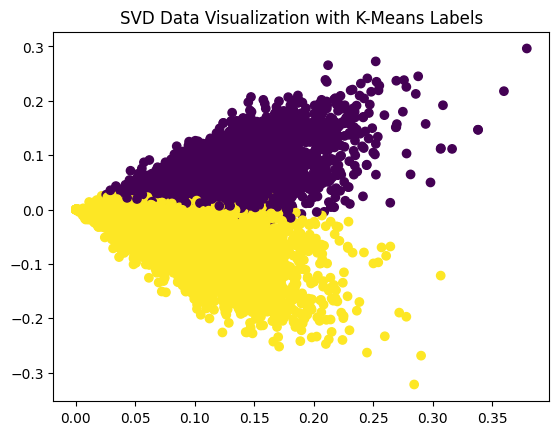

In [42]:
plt.scatter(svd_km[:,0],svd_km[:,1],c=ground_truth)
plt.title("SVD Data Visualization with Ground Truth Labels")
plt.savefig('Q81.png',dpi=300,bbox_inches='tight')
plt.show()
plt.scatter(svd_km[:,0],svd_km[:,1],c=y_svd)
plt.title("SVD Data Visualization with K-Means Labels")
plt.savefig('Q82.png',dpi=300,bbox_inches='tight')
plt.show()

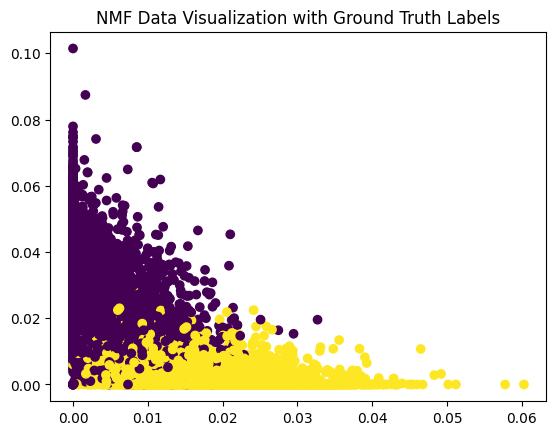

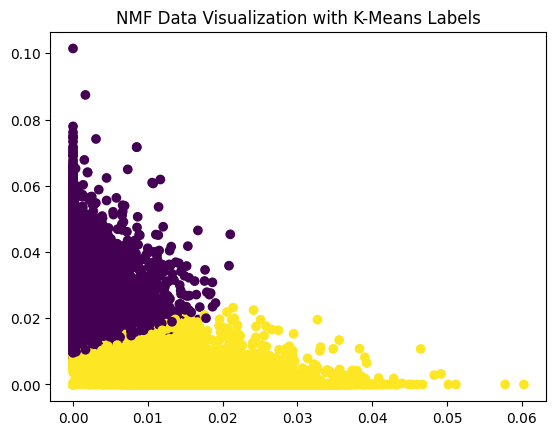

In [43]:
plt.scatter(nmf_km[:,0],nmf_km[:,1],c=ground_truth)
plt.title("NMF Data Visualization with Ground Truth Labels")
plt.savefig('Q83.png',dpi=300,bbox_inches='tight')
plt.show()
plt.scatter(nmf_km[:,0],nmf_km[:,1],c=y_svd)
plt.title("NMF Data Visualization with K-Means Labels")
plt.savefig('Q84.png',dpi=300,bbox_inches='tight')
plt.show()

# Question 9 

### There are several visual cues in the preceding figures indicating that the data distribution is not well‐suited for K‐means clustering.
### K‐means requires clusters to be convex and roughly isotropic. However, in both the SVD and NMF plots, the data appear as elongated, irregular shapes rather than spherical clusters. Furthermore, the NMF results show unevenly sized clusters across the two classes.
### K‐means++ aims to initialize centroids so that the resulting clusters are well‐spaced. Yet in both the SVD and NMF visualizations, the two clusters exhibit considerable overlap, with centroids that remain close together in Euclidean distance. This overlap yields no clear boundary between the clusters and results in low homogeneity and V‐measure scores.
### K‐means assumes clusters follow a univariate (Gaussian) distribution. In both SVD and NMF plots, we see the two clusters having different variances—especially in the NMF results, where the yellow cluster is more tightly packed than the brown one. Consequently, outliers and noise can substantially shift the centroids.

# Question 10

### "specify settings you choose and why"

### Instead of guessing appropriate parameters for the SVD and NMF, a better approach would be to find the best value of 'r' for both SVD and NMF (decided by the average value of the five clustering metrics.)

In [6]:
dataset = fetch_20newsgroups(subset = 'all',shuffle = True, random_state = 0,remove=('headers','footers'))
vectorizer = CountVectorizer(stop_words='english',min_df=3)
tfidf_transformer = TfidfTransformer()
data_vec_all = vectorizer.fit_transform(dataset.data)
features_all = tfidf_transformer.fit_transform(data_vec_all)


In [45]:
svd_hs = []
svd_cs = []
svd_vs = []
svd_ari = []
svd_ms = []

km = KMeans(n_clusters=20, init='k-means++', max_iter=5000, n_init=200, random_state=0)
r = [1,2,3,4,5,6,7,8,9,10,20,50,100,300]

for i in range(len(r)):
    print('Testing SVD for r = ',r[i])
    svd = TruncatedSVD(n_components=r[i], random_state=0)
    svd_km = svd.fit_transform(features_all)
    kmean_svd = km.fit(svd_km)
    svd_hs.append(homogeneity_score(dataset.target, kmean_svd.labels_))
    svd_cs.append(completeness_score(dataset.target, kmean_svd.labels_))
    svd_vs.append(v_measure_score(dataset.target, kmean_svd.labels_))
    svd_ari.append(adjusted_rand_score(dataset.target, kmean_svd.labels_))
    svd_ms.append(adjusted_mutual_info_score(dataset.target, kmean_svd.labels_)) 
print('Done testing SVD')


nmf_hs = []
nmf_cs = []
nmf_vs = []
nmf_ari = []
nmf_ms = []

for i in range(len(r)): 
    print('Testing NMF for r = ',r[i])
    nmf = NMF(n_components=r[i], init='random', random_state=0, max_iter=400)
    nmf_km = nmf.fit_transform(features_all)
    kmean_nmf = km.fit(nmf_km)
    nmf_hs.append(homogeneity_score(dataset.target, kmean_nmf.labels_))
    nmf_cs.append(completeness_score(dataset.target, kmean_nmf.labels_))
    nmf_vs.append(v_measure_score(dataset.target, kmean_nmf.labels_))
    nmf_ari.append(adjusted_rand_score(dataset.target, kmean_nmf.labels_))
    nmf_ms.append(adjusted_mutual_info_score(dataset.target, kmean_nmf.labels_))
print('Done testing NMF')

Testing SVD for r =  1
Testing SVD for r =  2
Testing SVD for r =  3
Testing SVD for r =  4
Testing SVD for r =  5
Testing SVD for r =  6
Testing SVD for r =  7
Testing SVD for r =  8
Testing SVD for r =  9
Testing SVD for r =  10
Testing SVD for r =  20
Testing SVD for r =  50
Testing SVD for r =  100
Testing SVD for r =  300
Done testing SVD
Testing NMF for r =  1
Testing NMF for r =  2
Testing NMF for r =  3
Testing NMF for r =  4
Testing NMF for r =  5
Testing NMF for r =  6
Testing NMF for r =  7
Testing NMF for r =  8
Testing NMF for r =  9
Testing NMF for r =  10
Testing NMF for r =  20
Testing NMF for r =  50
Testing NMF for r =  100
Testing NMF for r =  300
Done testing NMF


### The best values of 'r' for SVD and NMF are reported below:

In [46]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(svd_hs, svd_cs, svd_vs, svd_ari, svd_ms)]]
best_r_SVD = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for SVD (according to avg. metric): ', best_r_SVD, ', avg. value of 5 metrics: ',max(avg_metrics))

avg_metrics_nmf = [y/5 for y in [sum(x) for x in zip(nmf_hs, nmf_cs, nmf_vs, nmf_ari, nmf_ms)]]
best_r_NMF = r[avg_metrics_nmf.index(max(avg_metrics_nmf))]
print('Best value of r for NMF (according to avg. metric): ', best_r_NMF, ', avg. value of 5 metrics: ',max(avg_metrics_nmf))

Best value of r for SVD (according to avg. metric):  100 , avg. value of 5 metrics:  0.30712363595873804
Best value of r for NMF (according to avg. metric):  20 , avg. value of 5 metrics:  0.2759768413761781


### Here are the plots and metrics for SVD followed by NMF respectively:

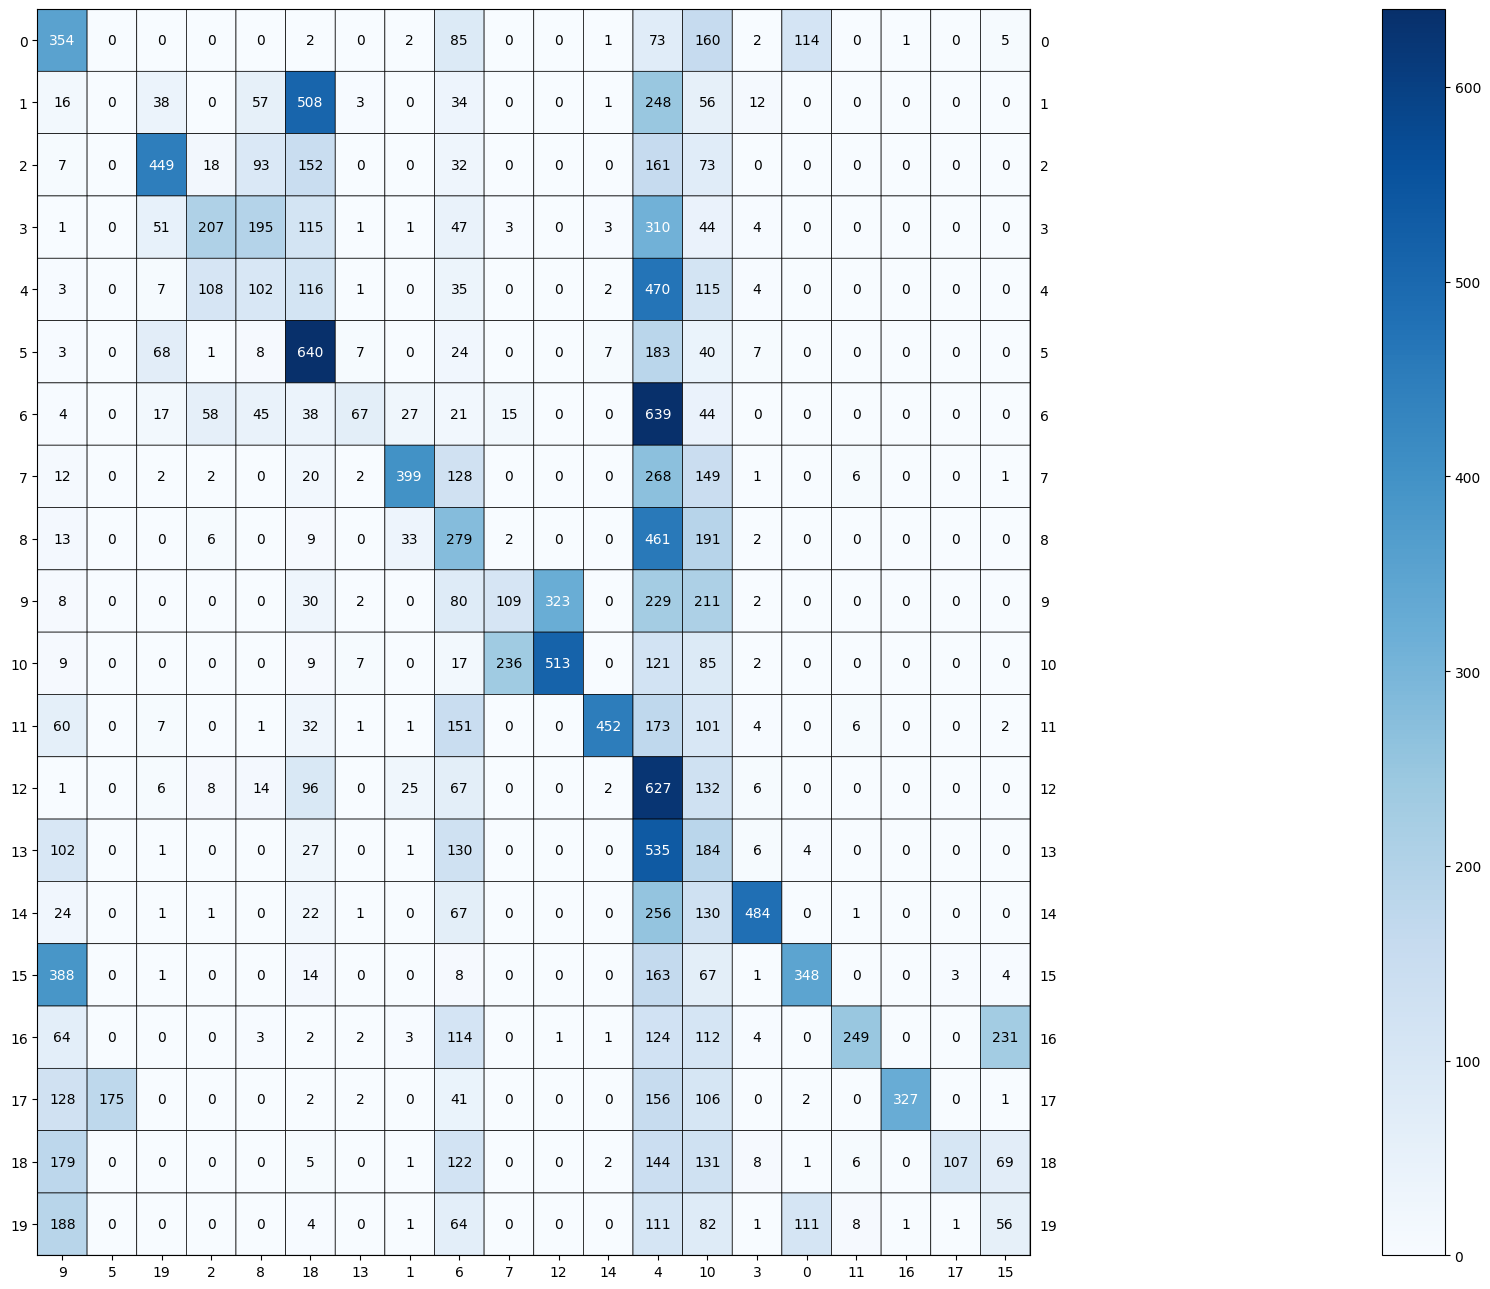

Homogeneity (SVD, best r): 0.325
Completeness (SVD, best r): 0.394
V-measure (SVD, best r): 0.356
Adjusted Rand-Index (SVD, best r): 0.106
Adjusted Mutual Information Score (SVD, best r): 0.354


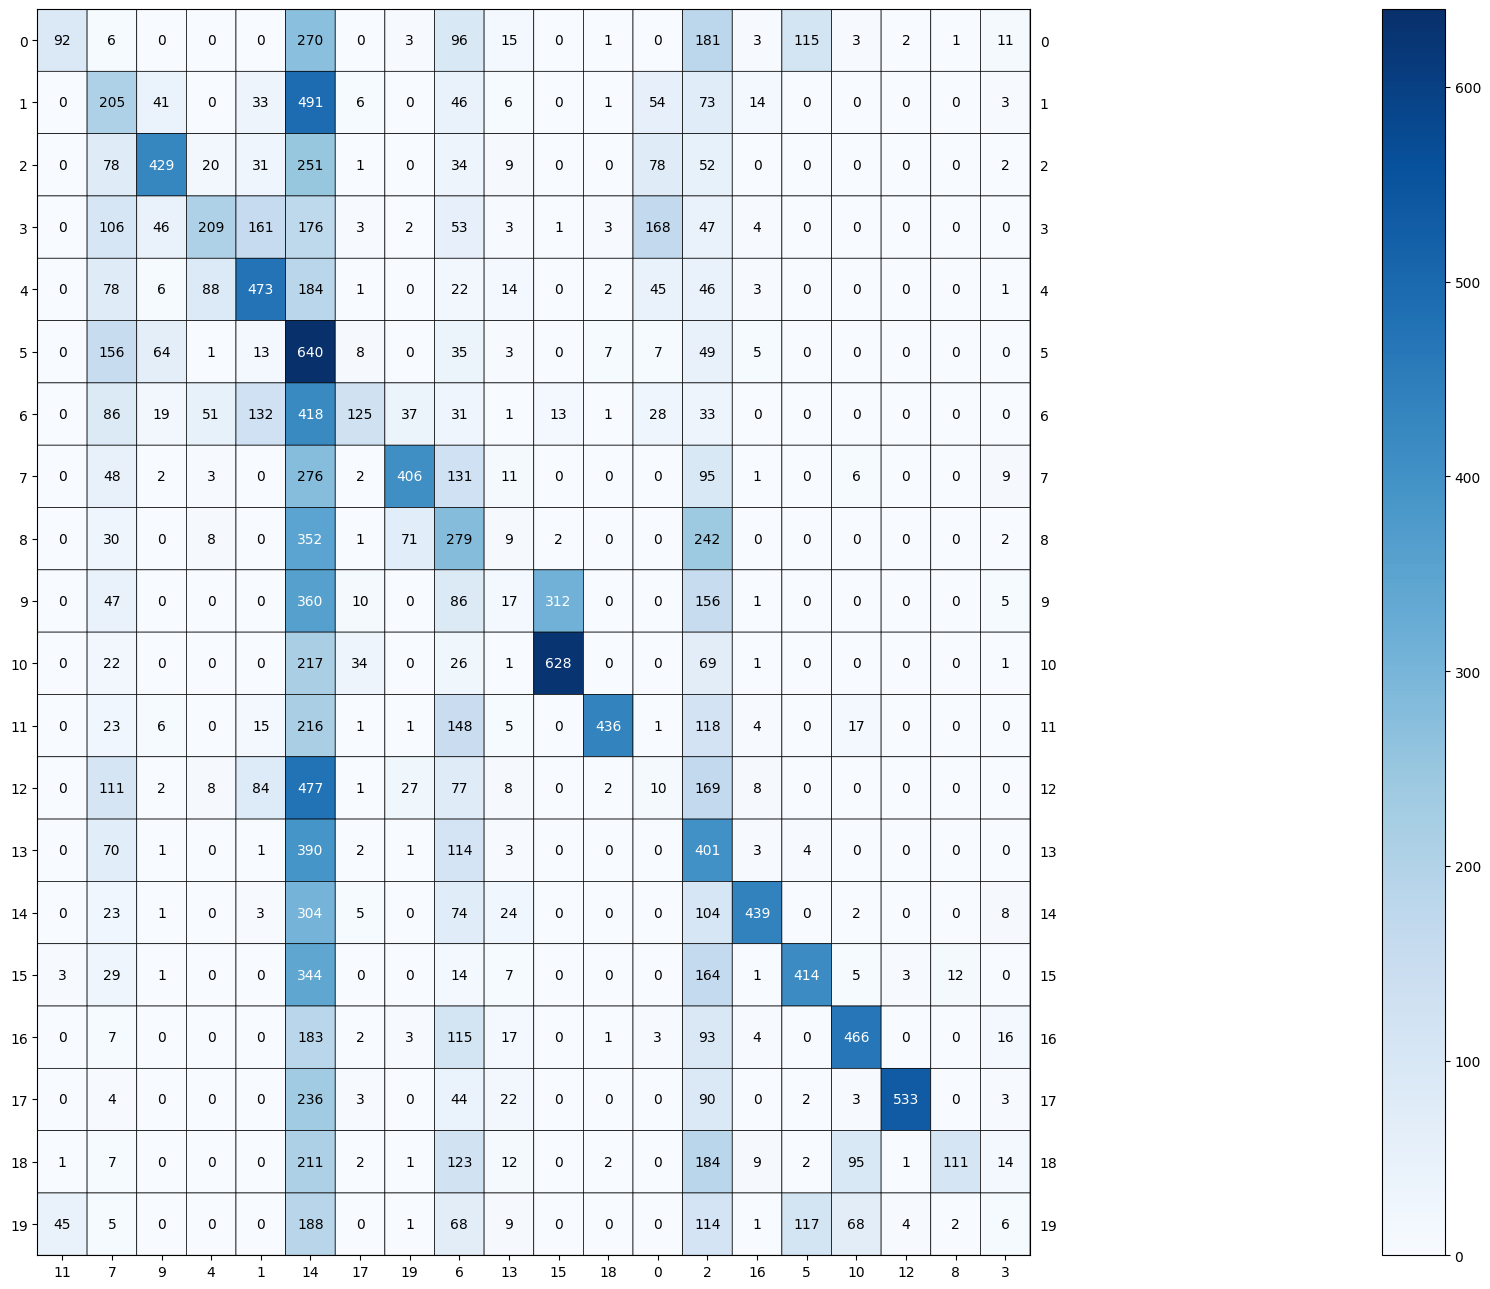

Homogeneity (NMF, best r): 0.292
Completeness (NMF, best r): 0.363
V-measure (NMF, best r): 0.323
Adjusted Rand-Index (NMF, best r): 0.082
Adjusted Mutual Information Score (NMF, best r): 0.321


In [47]:
svd = TruncatedSVD(n_components=best_r_SVD, random_state=0)
svd_km = svd.fit_transform(features_all)
kmean_svd = km.fit(svd_km)
cm = confusion_matrix(dataset.target, kmean_svd.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,13),pic_fname = 'Q10a.png')
print("Homogeneity (SVD, best r): %0.3f" % homogeneity_score(dataset.target, kmean_svd.labels_))
print("Completeness (SVD, best r): %0.3f" % completeness_score(dataset.target, kmean_svd.labels_))
print("V-measure (SVD, best r): %0.3f" % v_measure_score(dataset.target, kmean_svd.labels_))
print("Adjusted Rand-Index (SVD, best r): %.3f"% adjusted_rand_score(dataset.target, kmean_svd.labels_))
print("Adjusted Mutual Information Score (SVD, best r): %.3f"% adjusted_mutual_info_score(dataset.target, kmean_svd.labels_))

nmf = NMF(n_components=best_r_NMF, init='random', random_state=0, max_iter=400)
nmf_km = nmf.fit_transform(features_all)
kmean_nmf = km.fit(nmf_km)
cm = confusion_matrix(dataset.target, kmean_nmf.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,13),pic_fname = 'Q10b.png')
print("Homogeneity (NMF, best r): %0.3f" % homogeneity_score(dataset.target, kmean_nmf.labels_))
print("Completeness (NMF, best r): %0.3f" % completeness_score(dataset.target, kmean_nmf.labels_))
print("V-measure (NMF, best r): %0.3f" % v_measure_score(dataset.target, kmean_nmf.labels_))
print("Adjusted Rand-Index (NMF, best r): %.3f"% adjusted_rand_score(dataset.target, kmean_nmf.labels_))
print("Adjusted Mutual Information Score (NMF, best r): %.3f"% adjusted_mutual_info_score(dataset.target, kmean_nmf.labels_))

# Question 11

### The 6 results (plots + metrics) are as follows. We also report the performance of the best 'n_components' value for both 'cosine' and 'euclidean'.

============================== Testing UMAP (euclidean) for r = 5 ==============================


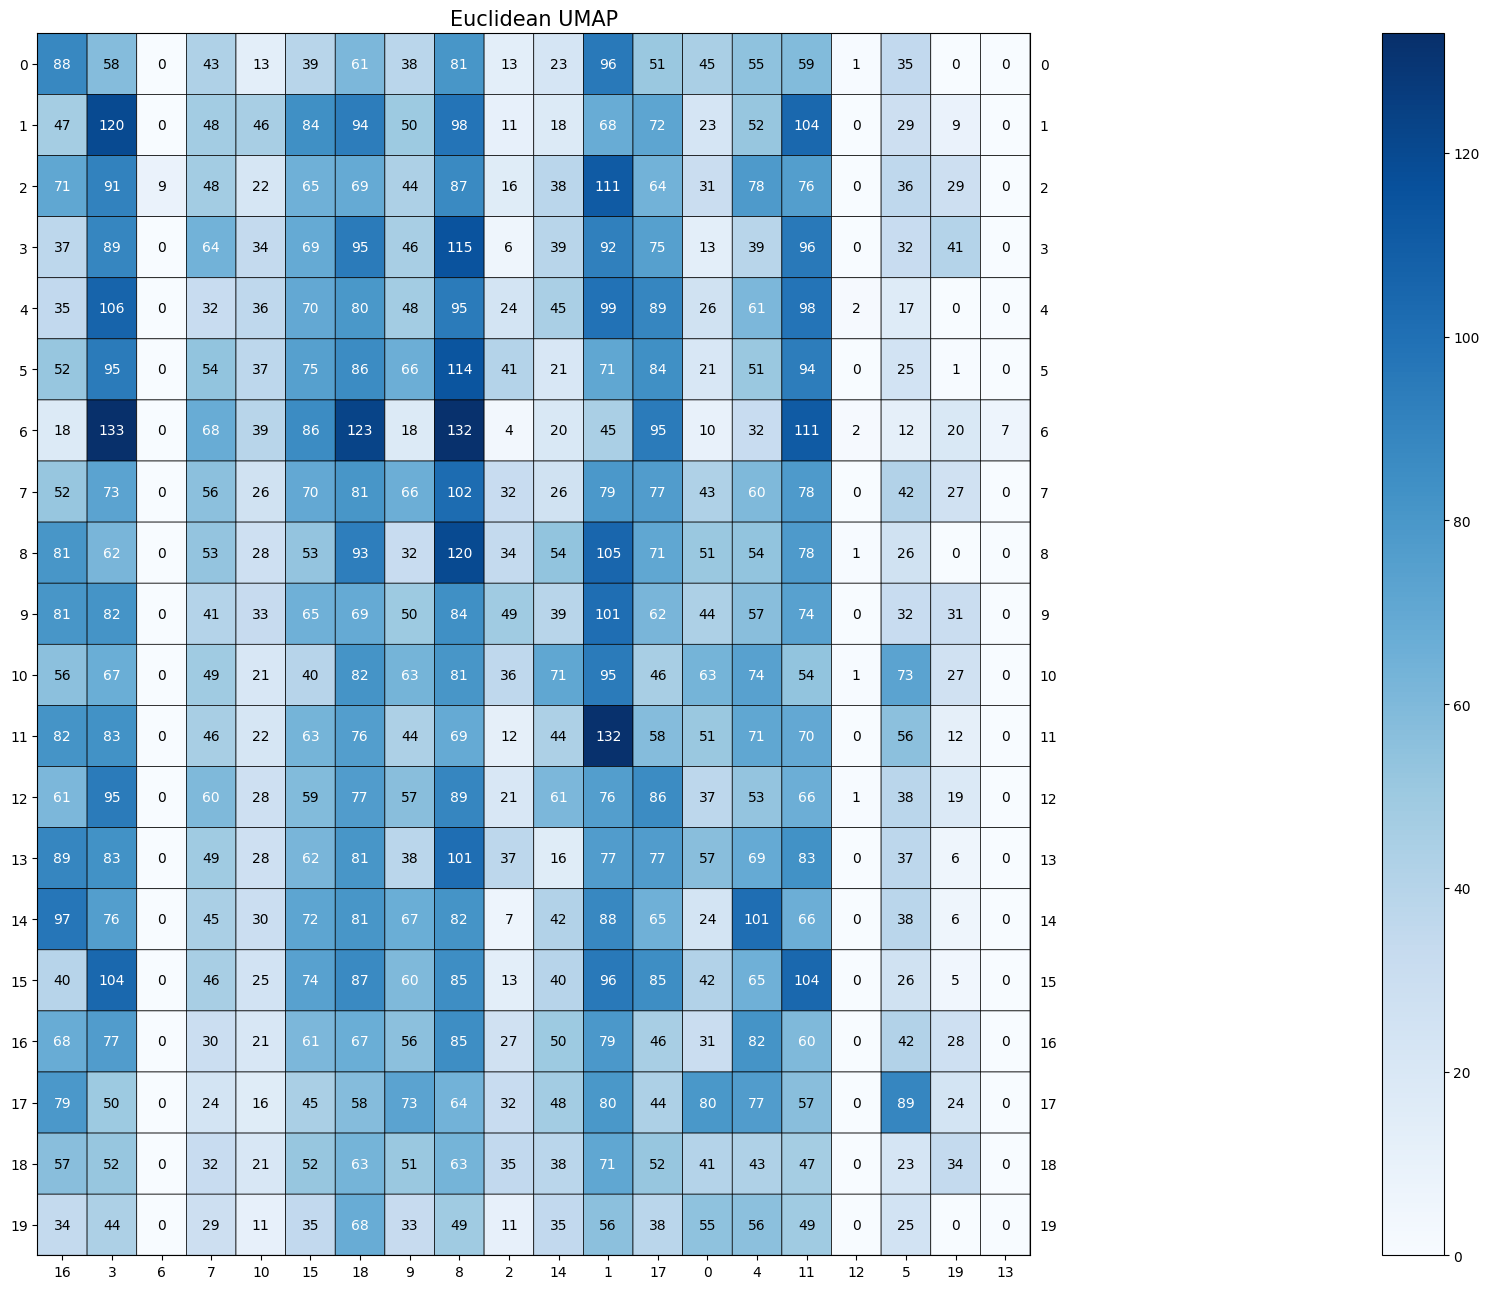

Homogeneity (UMAP (euclidean)):  0.01589457751660951
Completeness (UMAP (euclidean)):  0.01726636885537997
V-measure (UMAP (euclidean)):  0.016552099275069277
Adjusted Rand-Index (UMAP (euclidean)):  0.003173324908904825
Adjusted Mutual Information Score (UMAP (euclidean)):  0.013270084869054455
============================== Testing UMAP (cosine) for r = 5 ==============================


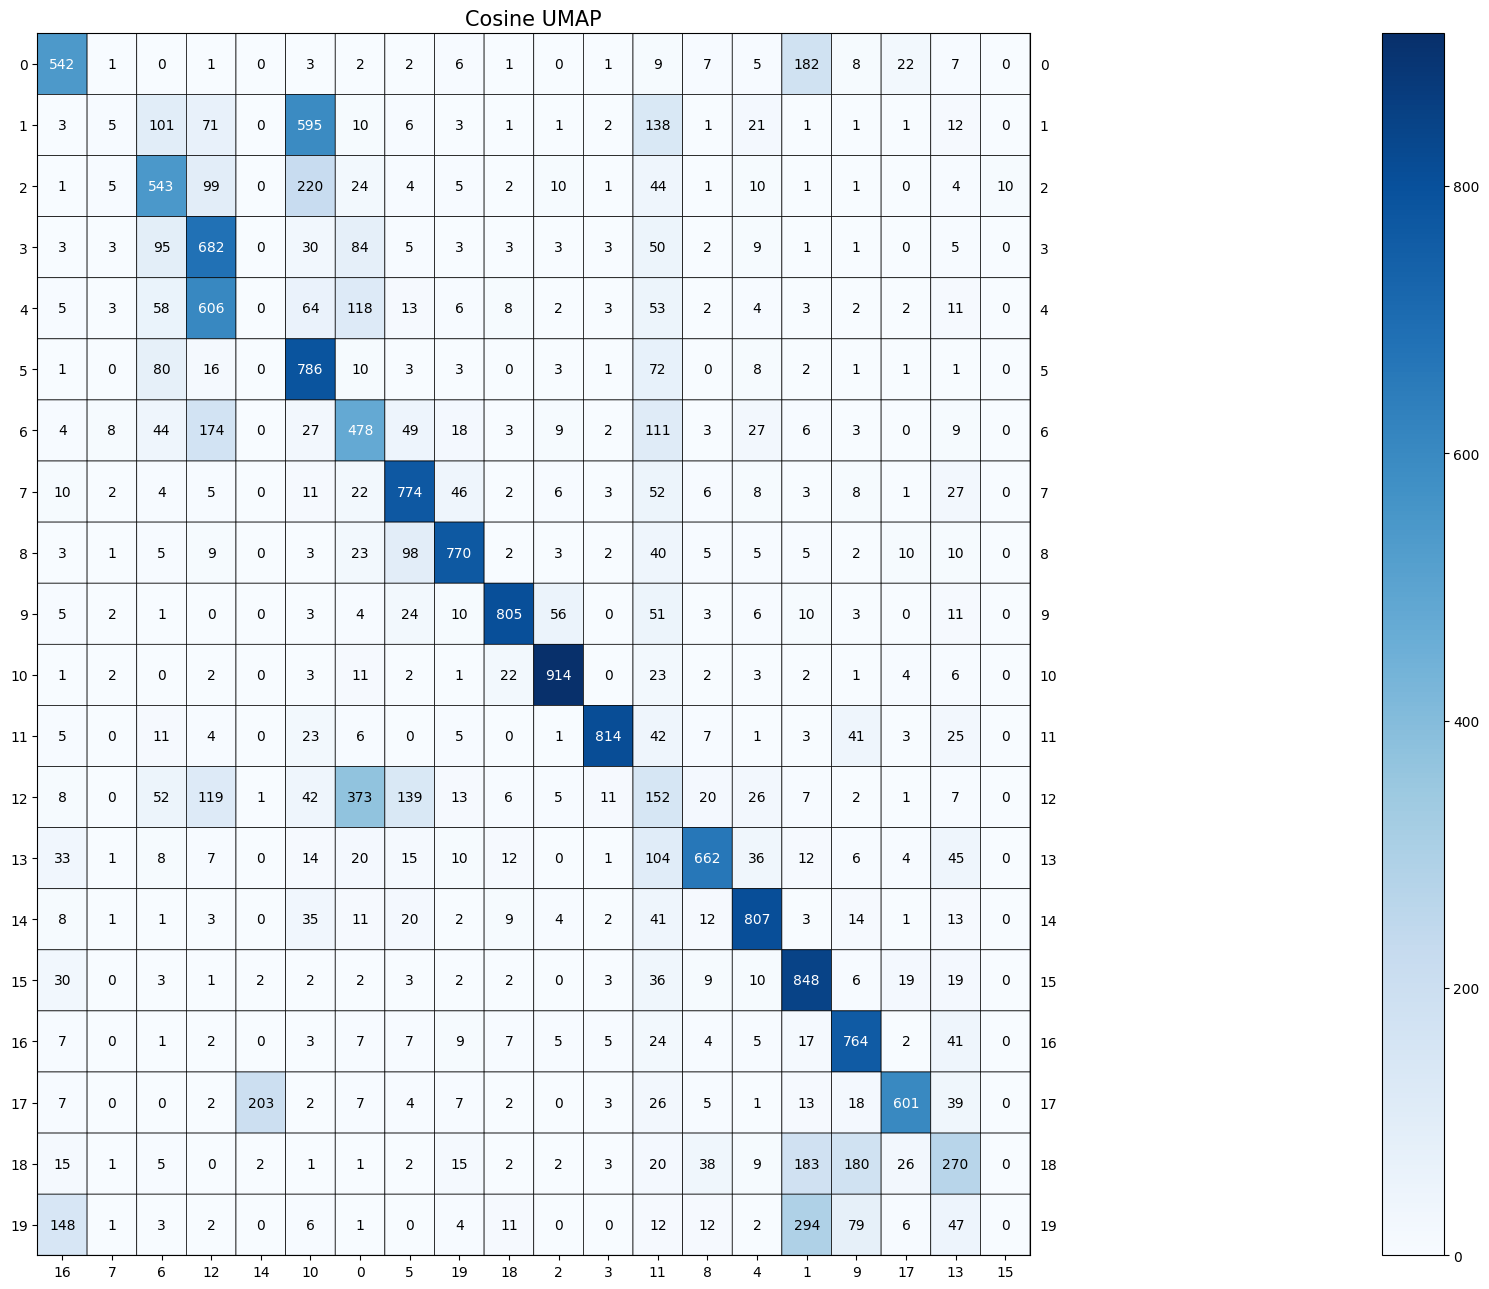

Homogeneity (UMAP (cosine)):  0.5583071634472664
Completeness (UMAP (cosine)):  0.590476136211523
V-measure (UMAP (cosine)):  0.5739412416414384
Adjusted Rand-Index (UMAP (cosine)):  0.439210756516871
Adjusted Mutual Information Score (UMAP (cosine)):  0.5725139366459726
Done testing
============================== Testing UMAP (euclidean) for r = 20 ==============================


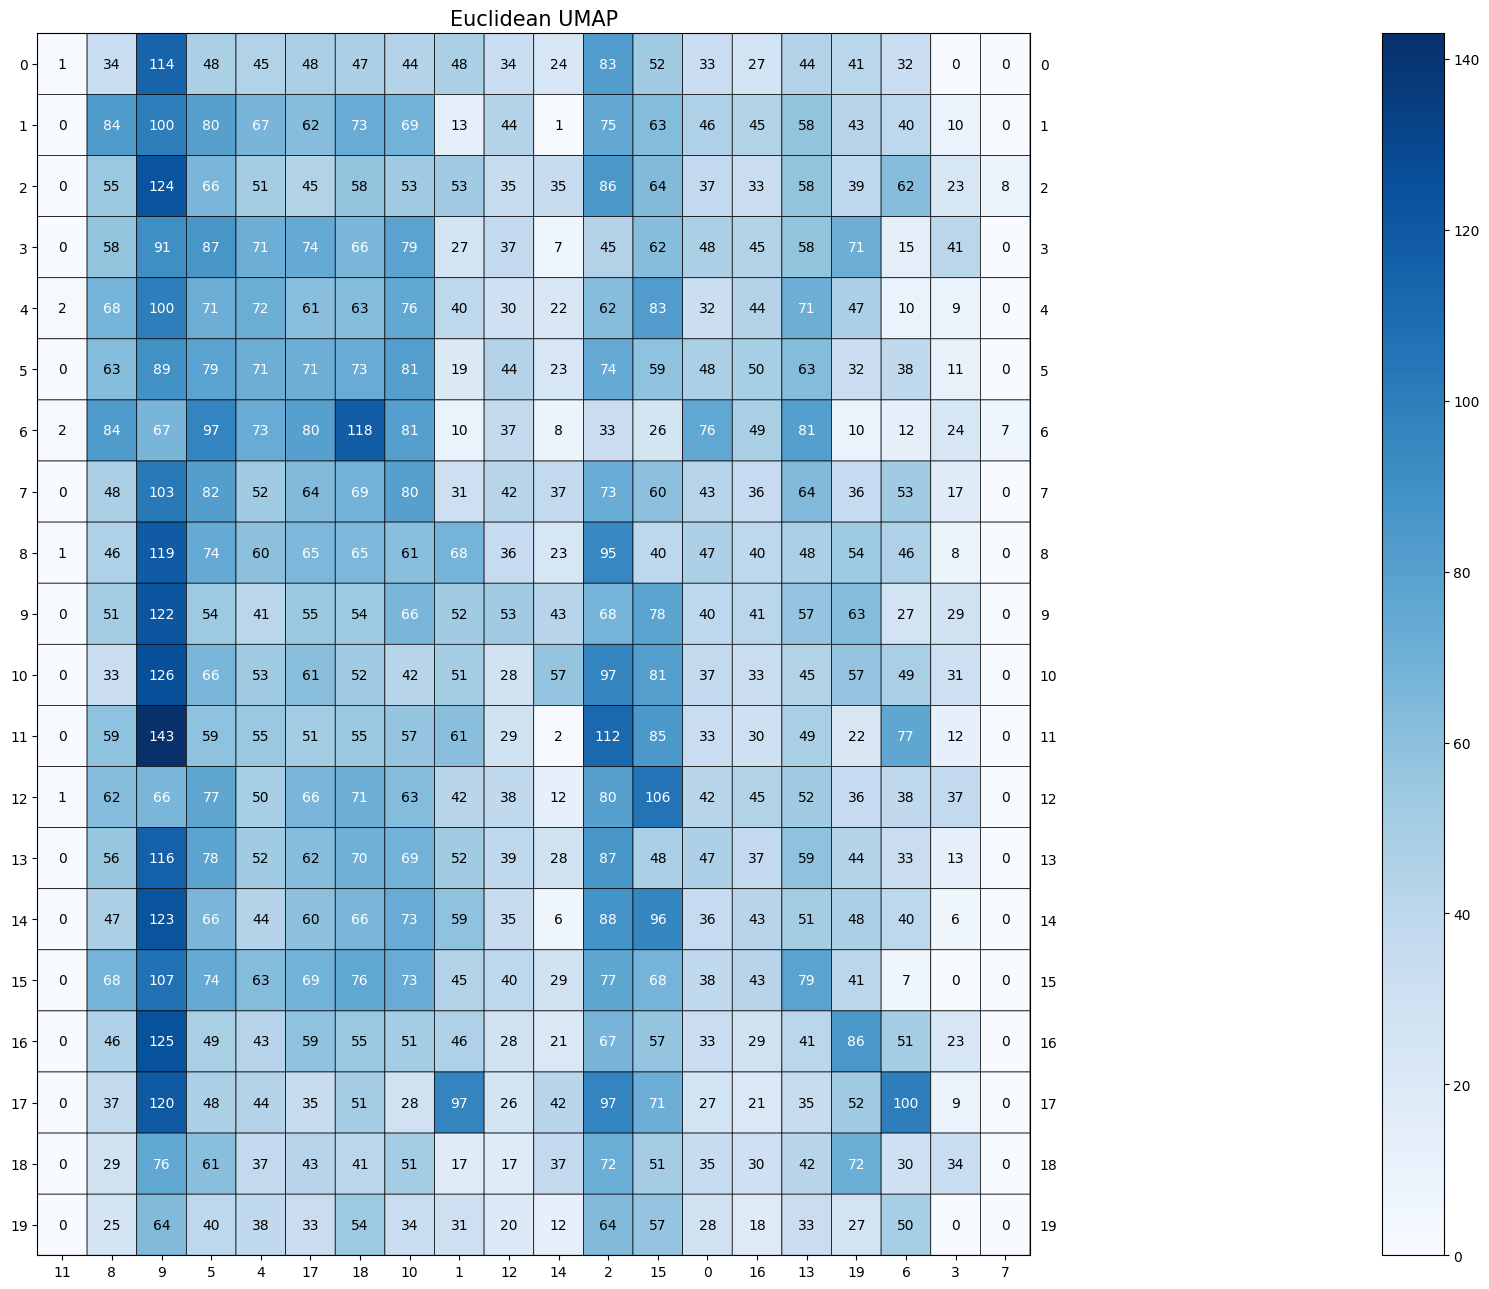

Homogeneity (UMAP (euclidean)):  0.015998273225196178
Completeness (UMAP (euclidean)):  0.016935016526173356
V-measure (UMAP (euclidean)):  0.0164533226716391
Adjusted Rand-Index (UMAP (euclidean)):  0.0031383832487236374
Adjusted Mutual Information Score (UMAP (euclidean)):  0.01318277537341495
============================== Testing UMAP (cosine) for r = 20 ==============================


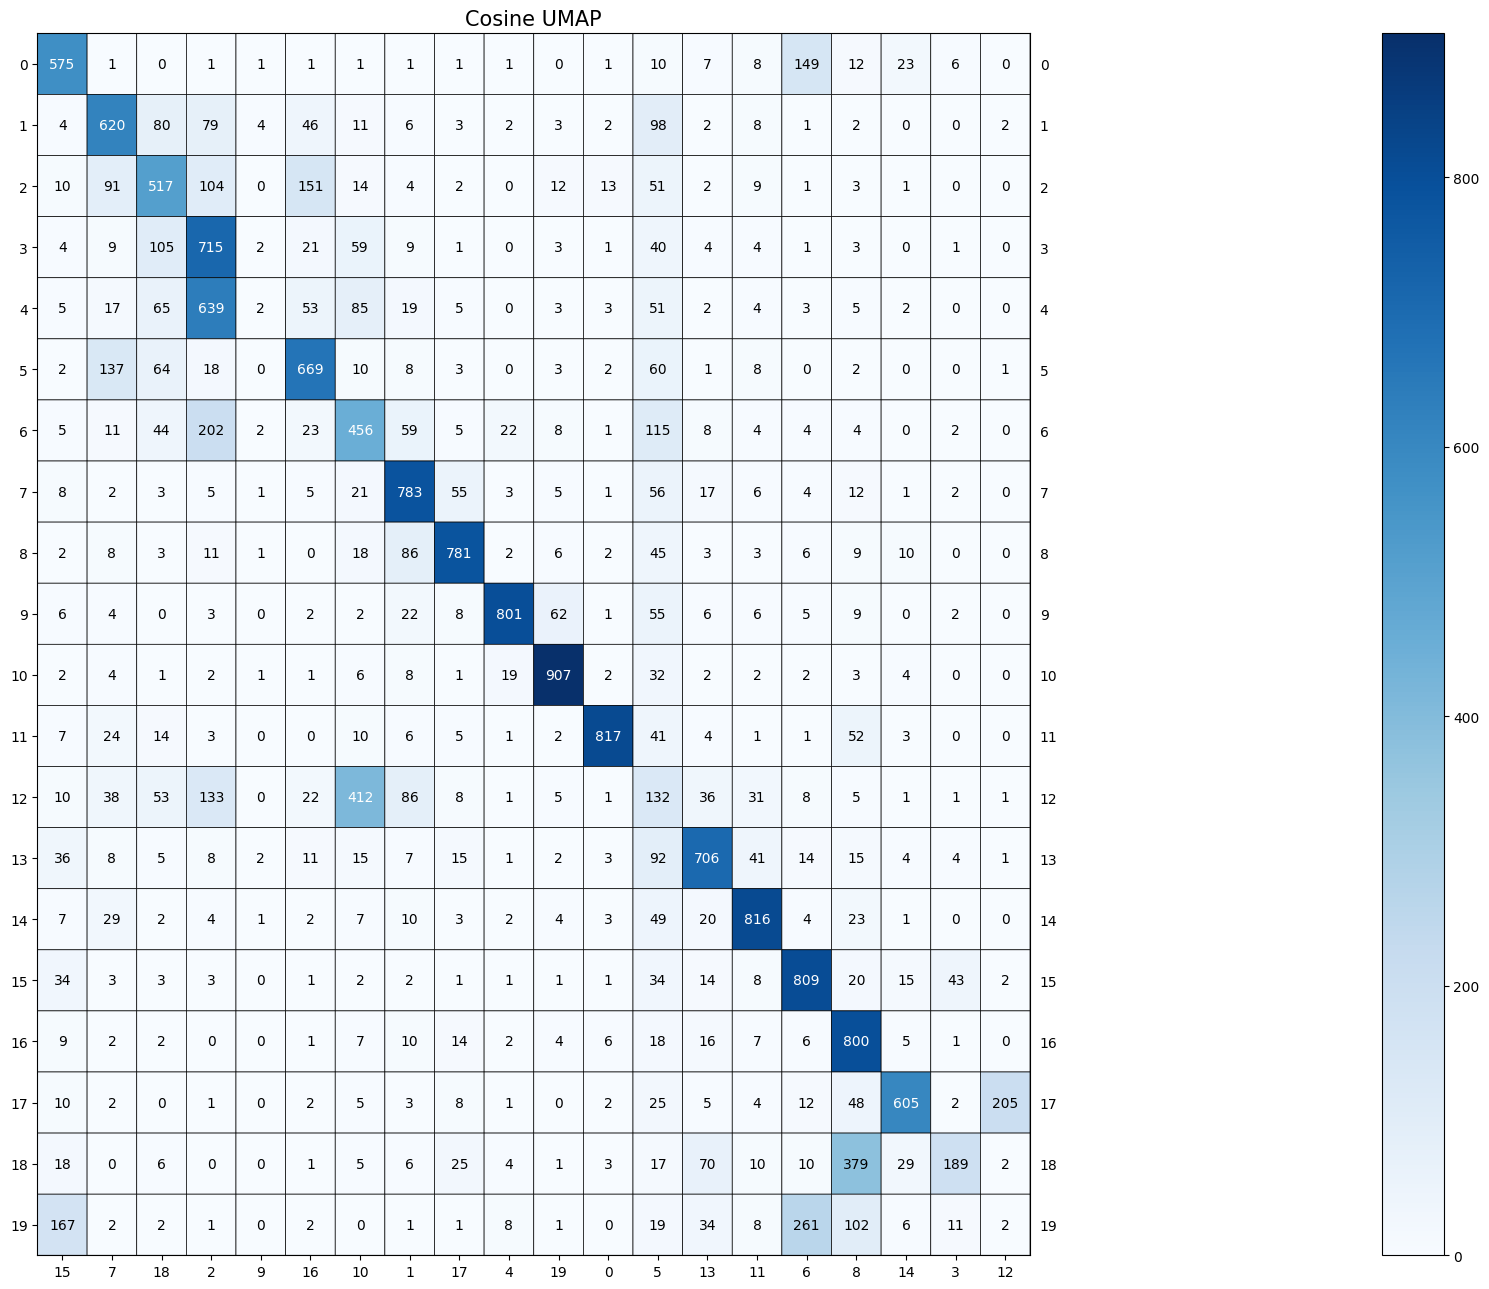

Homogeneity (UMAP (cosine)):  0.5750867653998235
Completeness (UMAP (cosine)):  0.5984367535808426
V-measure (UMAP (cosine)):  0.5865294582457328
Adjusted Rand-Index (UMAP (cosine)):  0.45876914152625276
Adjusted Mutual Information Score (UMAP (cosine)):  0.5851573659357263
Done testing
============================== Testing UMAP (euclidean) for r = 200 ==============================


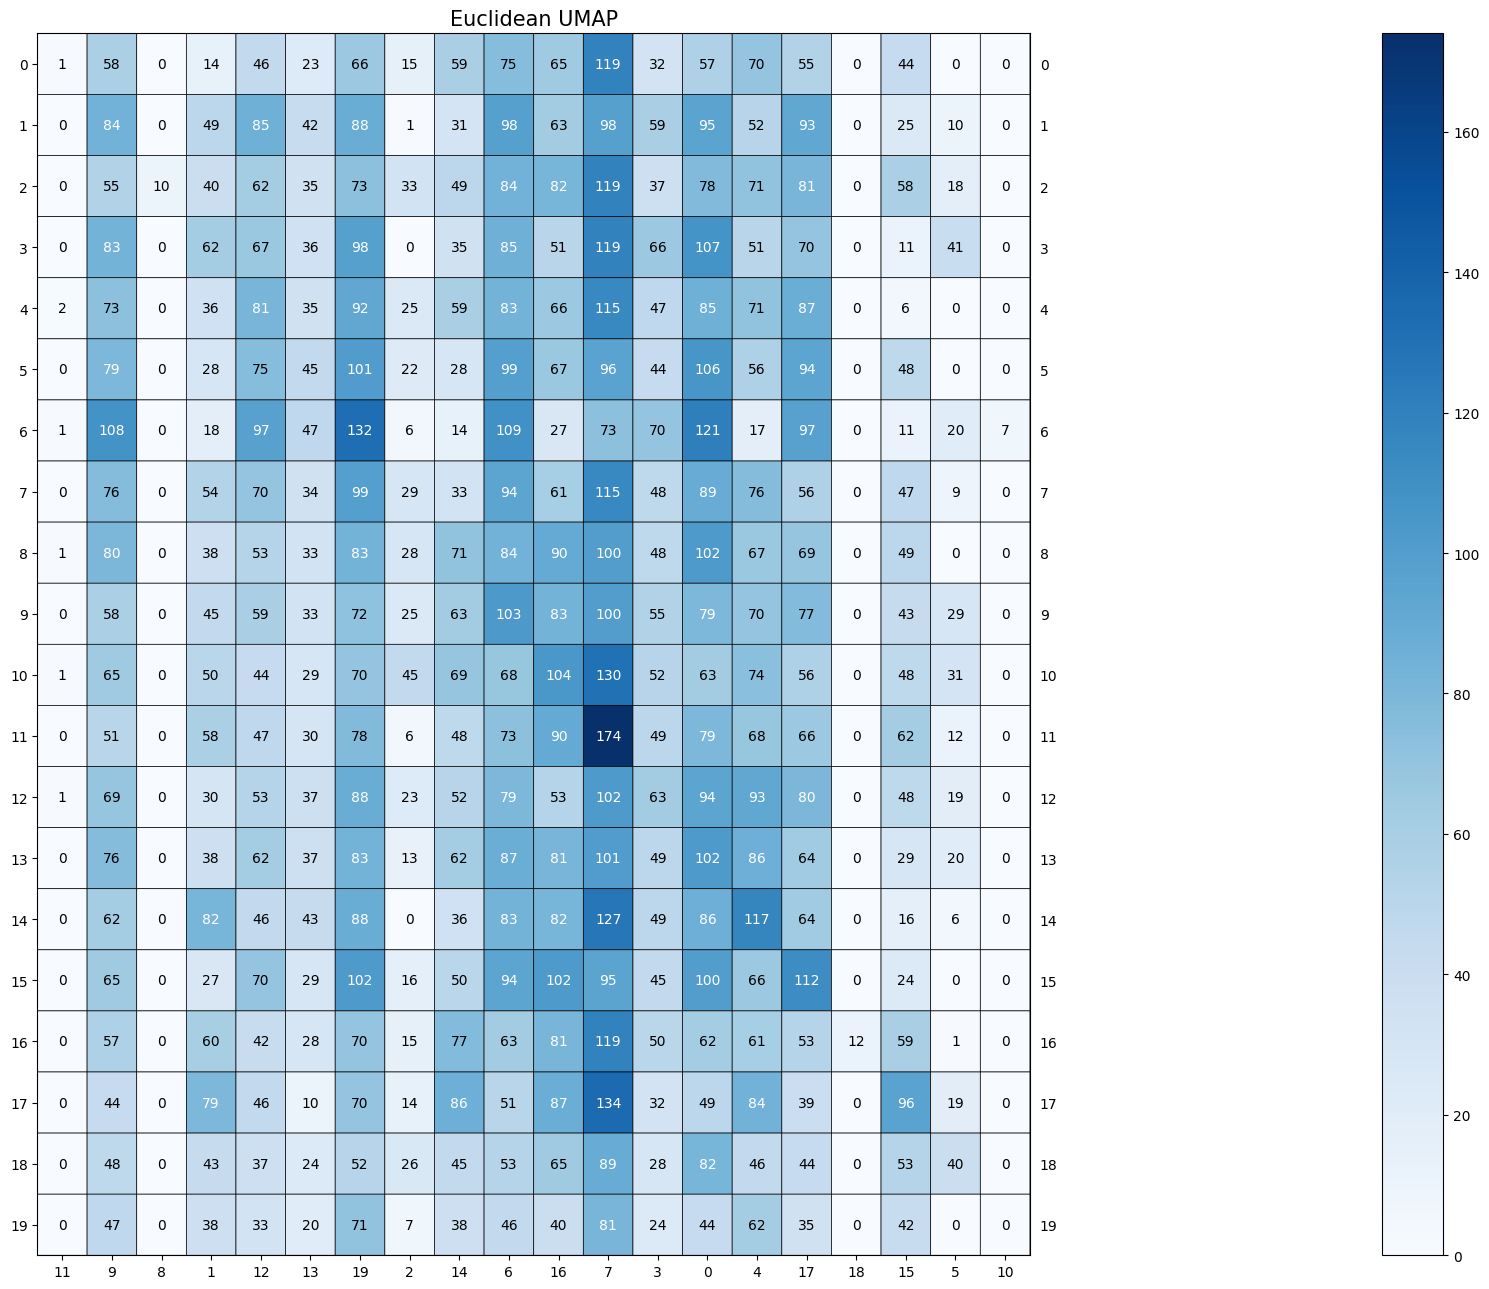

Homogeneity (UMAP (euclidean)):  0.017197368010840364
Completeness (UMAP (euclidean)):  0.01915596187162877
V-measure (UMAP (euclidean)):  0.018123903750940307
Adjusted Rand-Index (UMAP (euclidean)):  0.003139368919604878
Adjusted Mutual Information Score (UMAP (euclidean)):  0.01479681400356057
============================== Testing UMAP (cosine) for r = 200 ==============================


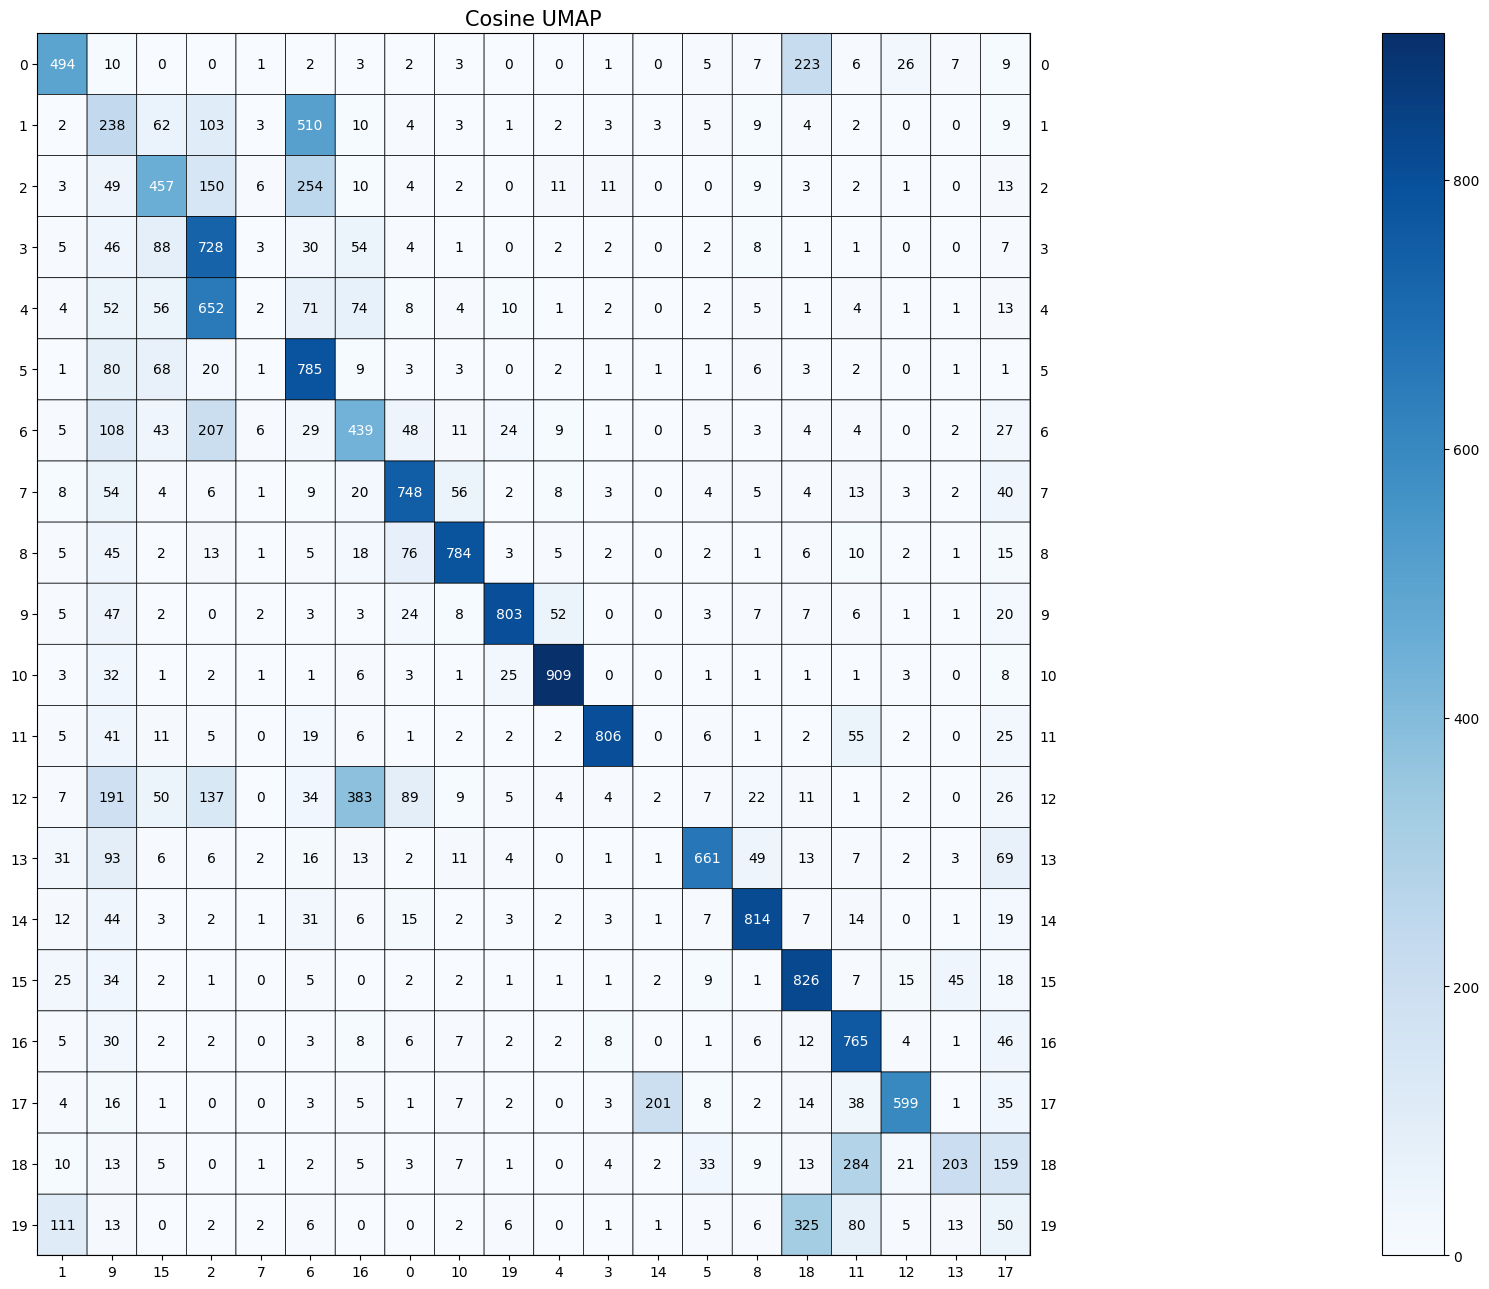

Homogeneity (UMAP (cosine)):  0.5639679509605356
Completeness (UMAP (cosine)):  0.591519872441897
V-measure (UMAP (cosine)):  0.5774154320920242
Adjusted Rand-Index (UMAP (cosine)):  0.4354622252861088
Adjusted Mutual Information Score (UMAP (cosine)):  0.5760060989968413
Done testing


In [4]:
euc_hs = []
euc_cs = []
euc_vs = []
euc_ari = []
euc_ms = []
cos_hs = []
cos_cs = []
cos_vs = []
cos_ari = []
cos_ms = []

km = KMeans(n_clusters=20, init='k-means++', max_iter=5000, n_init=200, random_state=0)
r = [5,20,200]

for i in range(len(r)):
    print("=" * 30, "Testing UMAP (euclidean) for r =", r[i], "=" * 30)
    Umap_euc = umap.UMAP(n_components=r[i], metric='euclidean').fit_transform(features_all)
    kmean_euc = km.fit(Umap_euc)
    euc_hs.append(homogeneity_score(dataset.target, kmean_euc.labels_))
    euc_cs.append(completeness_score(dataset.target, kmean_euc.labels_))
    euc_vs.append(v_measure_score(dataset.target, kmean_euc.labels_))
    euc_ari.append(adjusted_rand_score(dataset.target, kmean_euc.labels_))
    euc_ms.append(adjusted_mutual_info_score(dataset.target, kmean_euc.labels_)) 
    cm = confusion_matrix(dataset.target, kmean_euc.labels_)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'Euclidean UMAP', size=(15,13),pic_fname = f'Q11_euc_{i}.png')
    print('Homogeneity (UMAP (euclidean)): ',euc_hs[-1])
    print('Completeness (UMAP (euclidean)): ',euc_cs[-1]) 
    print('V-measure (UMAP (euclidean)): ',euc_vs[-1]) 
    print('Adjusted Rand-Index (UMAP (euclidean)): ',euc_ari[-1]) 
    print('Adjusted Mutual Information Score (UMAP (euclidean)): ',euc_ms[-1])
    
    print("=" * 30, "Testing UMAP (cosine) for r =", r[i], "=" * 30)
    Umap_cos = umap.UMAP(n_components=r[i], metric='cosine').fit_transform(features_all)
    kmean_cos = km.fit(Umap_cos)
    cos_hs.append(homogeneity_score(dataset.target, kmean_cos.labels_))
    cos_cs.append(completeness_score(dataset.target, kmean_cos.labels_))
    cos_vs.append(v_measure_score(dataset.target, kmean_cos.labels_))
    cos_ari.append(adjusted_rand_score(dataset.target, kmean_cos.labels_))
    cos_ms.append(adjusted_mutual_info_score(dataset.target, kmean_cos.labels_))
    cm = confusion_matrix(dataset.target, kmean_cos.labels_)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'Cosine UMAP', size=(15,13),pic_fname = f'Q11_cos_{i}.png') 
    print('Homogeneity (UMAP (cosine)): ',cos_hs[-1])
    print('Completeness (UMAP (cosine)): ',cos_cs[-1]) 
    print('V-measure (UMAP (cosine)): ',cos_vs[-1]) 
    print('Adjusted Rand-Index (UMAP (cosine)): ',cos_ari[-1]) 
    print('Adjusted Mutual Information Score (UMAP (cosine)): ',cos_ms[-1])
    print('Done testing')

In [5]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(euc_hs, euc_cs, euc_vs, euc_ari, euc_ms)]]
best_r_euc = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for Euclidean UMAP (according to avg. metric): ', best_r_euc, ', avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (UMAP (euclidean), best r): ',euc_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (UMAP (euclidean), best r): ',euc_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (UMAP (euclidean), best r): ',euc_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (UMAP (euclidean), best r): ',euc_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (UMAP (euclidean), best r): ',euc_ms[avg_metrics.index(max(avg_metrics))])
avg_metrics = [y/5 for y in [sum(x) for x in zip(cos_hs, cos_cs, cos_vs, cos_ari, cos_ms)]]
best_r_cos = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for Cosine UMAP (according to avg. metric): ', best_r_cos, ', avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (UMAP (cosine), best r): ',cos_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (UMAP (cosine), best r): ',cos_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (UMAP (cosine), best r): ',cos_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (UMAP (cosine), best r): ',cos_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (UMAP (cosine), best r): ',cos_ms[avg_metrics.index(max(avg_metrics))])

Best value of r for Euclidean UMAP (according to avg. metric):  200 , avg. value of 5 metrics:  0.014482683311314975
Metrics: 
Homogeneity (UMAP (euclidean), best r):  0.017197368010840364
Completeness (UMAP (euclidean), best r):  0.01915596187162877
V-measure (UMAP (euclidean), best r):  0.018123903750940307
Adjusted Rand-Index (UMAP (euclidean), best r):  0.003139368919604878
Adjusted Mutual Information Score (UMAP (euclidean), best r):  0.01479681400356057
Best value of r for Cosine UMAP (according to avg. metric):  20 , avg. value of 5 metrics:  0.5607958969376756
Metrics: 
Homogeneity (UMAP (cosine), best r):  0.5750867653998235
Completeness (UMAP (cosine), best r):  0.5984367535808426
V-measure (UMAP (cosine), best r):  0.5865294582457328
Adjusted Rand-Index (UMAP (cosine), best r):  0.45876914152625276
Adjusted Mutual Information Score (UMAP (cosine), best r):  0.5851573659357263


# Question 12

### Based on the reported metrics, UMAP with the Cosine distance and n_components=20 clearly performs the best overall. Its average score (around 0.56) and individual metrics (Homogeneity ≈ 0.58, Completeness ≈ 0.60, V-measure ≈ 0.59, ARI ≈ 0.46, AMI ≈ 0.59) are much higher than those achieved by Euclidean UMAP (whose best average metrics are around 0.014). This strong performance difference arises largely because text data (with meaningful frequency-based features) is generally better captured by cosine similarity, while Euclidean distance fails to separate the clusters effectively, as seen by its highly non-diagonal and stochastic contingency matrices.

### Which setting works best and why ?

### Cosine, n_components=20 gives the highest scores across Homogeneity, Completeness, V-measure, ARI, and AMI, indicating it best aligns cluster assignments with the ground-truth classes. n_components=20 strikes a balance between preserving enough local/global structure and reducing irrelevant variance in text features, thus producing more coherent clusters.

### What about the metric choice?

### Cosine works better than Euclidean for textual data because textual feature vectors often vary more meaningfully in angle than in raw magnitude, making cosine distance more suitable for capturing semantic similarity. Euclidean not only shows worse metrics but also lumps many different ground-truth classes into single clusters (as evident from the non-diagonal contingency table). This suggests it does not adequately capture the structure of the text-based feature space.

# Question 13

### First let us perform k=20 clustering on Sparse TF-IDF representations

In [7]:
kmeans = KMeans(n_clusters=20, init='k-means++', max_iter=5000, n_init=200, random_state=0)
kmean_tfidf = kmeans.fit(features_all)
print("Homogeneity: %0.3f" % homogeneity_score(dataset.target, kmean_tfidf.labels_))
print("Completeness: %0.3f" % completeness_score(dataset.target, kmean_tfidf.labels_))
print("V-measure: %0.3f" % v_measure_score(dataset.target, kmean_tfidf.labels_))
print("Adjusted Rand-Index: %.3f"% adjusted_rand_score(dataset.target, kmean_tfidf.labels_))
print("Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(dataset.target, kmean_tfidf.labels_))
print('Average:',(homogeneity_score(dataset.target, kmean_tfidf.labels_)+completeness_score(dataset.target, kmean_tfidf.labels_)+v_measure_score(dataset.target, kmean_tfidf.labels_)+adjusted_rand_score(dataset.target, kmean_tfidf.labels_)+adjusted_mutual_info_score(dataset.target, kmean_tfidf.labels_))/5)

Homogeneity: 0.338
Completeness: 0.387
V-measure: 0.361
Adjusted Rand-Index: 0.122
Adjusted Mutual Information Score: 0.359
Average: 0.31343186521609223


### Now, let us compare the average score of the 5 clustering metrics for each of the representations:

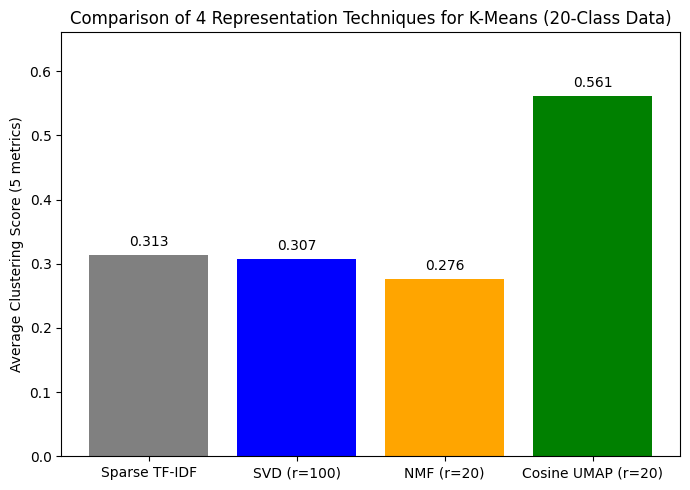

In [8]:
scores = {
    "Sparse TF-IDF": 0.31343186521609223,
    "SVD (r=100)":          0.30712363595873804,
    "NMF (r=20)":           0.2759768413761781,
    "Cosine UMAP (r=20)":   0.5607958969376756
}
labels = list(scores.keys())
values = list(scores.values())
plt.figure(figsize=(7, 5))
bars = plt.bar(labels, values, color=["gray", "blue", "orange", "green"])
plt.ylabel("Average Clustering Score (5 metrics)")
plt.title("Comparison of 4 Representation Techniques for K-Means (20-Class Data)")
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 0.01, 
        f"{height:.3f}",
        ha="center", 
        va="bottom"
    )

plt.ylim([0, max(values) + 0.1])
plt.tight_layout()
plt.savefig("Q13.png", dpi=300)
plt.show()

### Hence, we see that UMAP with n_components = 20 and metric = 'cosine' is the clear winner in terms of the mean of the 5 clustering scores.

# Question 14

### To compare the performance of 'ward' and 'single' linkage, we report the 5 clustering scores for each of them below:

In [9]:
print('best r:', best_r_cos)
Umap_cos = umap.UMAP(n_components=best_r_cos, metric='cosine').fit_transform(features_all)
ac_w = AgglomerativeClustering(n_clusters=20, linkage='ward').fit(Umap_cos)
ac_s = AgglomerativeClustering(n_clusters=20, linkage='single').fit(Umap_cos)
print("Agglomerative Clustering, Ward - Homogeneity: %0.3f" % homogeneity_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - Completeness: %0.3f" % completeness_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - V-measure: %0.3f" % v_measure_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - Adjusted Rand-Index: %.3f"% adjusted_rand_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(dataset.target, ac_w.labels_))
print()
print("Agglomerative Clustering, Single - Homogeneity: %0.3f" % homogeneity_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - Completeness: %0.3f" % completeness_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - V-measure: %0.3f" % v_measure_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - Adjusted Rand-Index: %.3f"% adjusted_rand_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(dataset.target, ac_s.labels_))

best r: 20
Agglomerative Clustering, Ward - Homogeneity: 0.562
Agglomerative Clustering, Ward - Completeness: 0.592
Agglomerative Clustering, Ward - V-measure: 0.577
Agglomerative Clustering, Ward - Adjusted Rand-Index: 0.435
Agglomerative Clustering, Ward - Adjusted Mutual Information Score: 0.575

Agglomerative Clustering, Single - Homogeneity: 0.017
Agglomerative Clustering, Single - Completeness: 0.393
Agglomerative Clustering, Single - V-measure: 0.032
Agglomerative Clustering, Single - Adjusted Rand-Index: 0.000
Agglomerative Clustering, Single - Adjusted Mutual Information Score: 0.027


# Question 15

### Two important hyperparameters for both algorithms are cluster selection epsilon and minimum samples per cluster. If epsilon is too small, most of the samples will be treated as outliers, while a large value erroneously merges different clusters together. Large values of minimum samples per cluster are helpful for rejecting noise in the data. Thus, we must also find a suitable value for both of the aforementioned parameters and hence, introduce a search over these as well. We report the best parameters after the search:

In [10]:
eps = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 3.0, 5.0, 10.0, 30.0, 50.0]
min_samples = [5, 15, 30, 60, 100, 200, 500, 1000, 3000]
min_cluster_sizes = [20, 100, 200]

eps_rec = []
min_samples_rec = []
min_cluster_size_rec = []

hdb_hs = []
hdb_cs = []
hdb_vs = []
hdb_ari = []
hdb_ms = []

for e in eps:
    for ms in min_samples:
        for mcs in min_cluster_sizes:
            print(f"Testing for eps={e}, min_samples={ms}, min_cluster_size={mcs}")
            hdb_labels = hdbscan.HDBSCAN(
                cluster_selection_epsilon=e,
                min_samples=ms,
                min_cluster_size=mcs,
                core_dist_n_jobs=-1
            ).fit_predict(Umap_cos)

            # Compute and store clustering metrics
            hdb_hs.append(homogeneity_score(dataset.target, hdb_labels))
            hdb_cs.append(completeness_score(dataset.target, hdb_labels))
            hdb_vs.append(v_measure_score(dataset.target, hdb_labels))
            hdb_ari.append(adjusted_rand_score(dataset.target, hdb_labels))
            hdb_ms.append(adjusted_mutual_info_score(dataset.target, hdb_labels))

            # Record the hyperparameters used
            eps_rec.append(e)
            min_samples_rec.append(ms)
            min_cluster_size_rec.append(mcs)

print("Done testing all combinations.")

all_avg_metrics = [
    (h + c + v + ari + ms_) / 5.0
    for h, c, v, ari, ms_ in zip(hdb_hs, hdb_cs, hdb_vs, hdb_ari, hdb_ms)
]

best_index = np.argmax(all_avg_metrics)
best_eps_hdb = eps_rec[best_index]
best_minSample_hdb = min_samples_rec[best_index]
best_minCluster_hdb = min_cluster_size_rec[best_index]
best_avg_metric = all_avg_metrics[best_index]

print("Best hyperparameters for HDBSCAN:")
print(f"  Epsilon:        {best_eps_hdb}")
print(f"  Min Samples:    {best_minSample_hdb}")
print(f"  Min Cluster Size: {best_minCluster_hdb}")
print(f"  (Avg. of 5 metrics: {best_avg_metric:.4f})")

print("Metrics at this best combination:")
print("  Homogeneity:                ", hdb_hs[best_index])
print("  Completeness:               ", hdb_cs[best_index])
print("  V-measure:                  ", hdb_vs[best_index])
print("  Adjusted Rand-Index (ARI):  ", hdb_ari[best_index])
print("  Adjusted Mutual Info (AMI): ", hdb_ms[best_index])


Testing for eps=0.01, min_samples=5, min_cluster_size=20
Testing for eps=0.01, min_samples=5, min_cluster_size=100
Testing for eps=0.01, min_samples=5, min_cluster_size=200
Testing for eps=0.01, min_samples=15, min_cluster_size=20
Testing for eps=0.01, min_samples=15, min_cluster_size=100
Testing for eps=0.01, min_samples=15, min_cluster_size=200
Testing for eps=0.01, min_samples=30, min_cluster_size=20
Testing for eps=0.01, min_samples=30, min_cluster_size=100
Testing for eps=0.01, min_samples=30, min_cluster_size=200
Testing for eps=0.01, min_samples=60, min_cluster_size=20
Testing for eps=0.01, min_samples=60, min_cluster_size=100
Testing for eps=0.01, min_samples=60, min_cluster_size=200
Testing for eps=0.01, min_samples=100, min_cluster_size=20
Testing for eps=0.01, min_samples=100, min_cluster_size=100
Testing for eps=0.01, min_samples=100, min_cluster_size=200
Testing for eps=0.01, min_samples=200, min_cluster_size=20
Testing for eps=0.01, min_samples=200, min_cluster_size=100
T

# Question 16

### From the contingency matrix, we observe that HDBSCAN identifies 11 major clusters. Many missing ground truth clusters appear merged with other clusters because they form a hierarchical (tree-like) rather than a strictly flat structure. The “-1” label marks outliers or noisy samples that the algorithm leaves unassigned. This merging seems to result from excessive smoothing influenced by hyperparameter choices—specifically not adjusting the minimum cluster size—which leads to the loss of low-density clusters. Moreover, the algorithm struggles with widely varying or sparsely distributed clusters in high-dimensional spaces, as often is the case with text data. Adjusting the minimum cluster size might enable the formation of more microclusters for low-density categories.

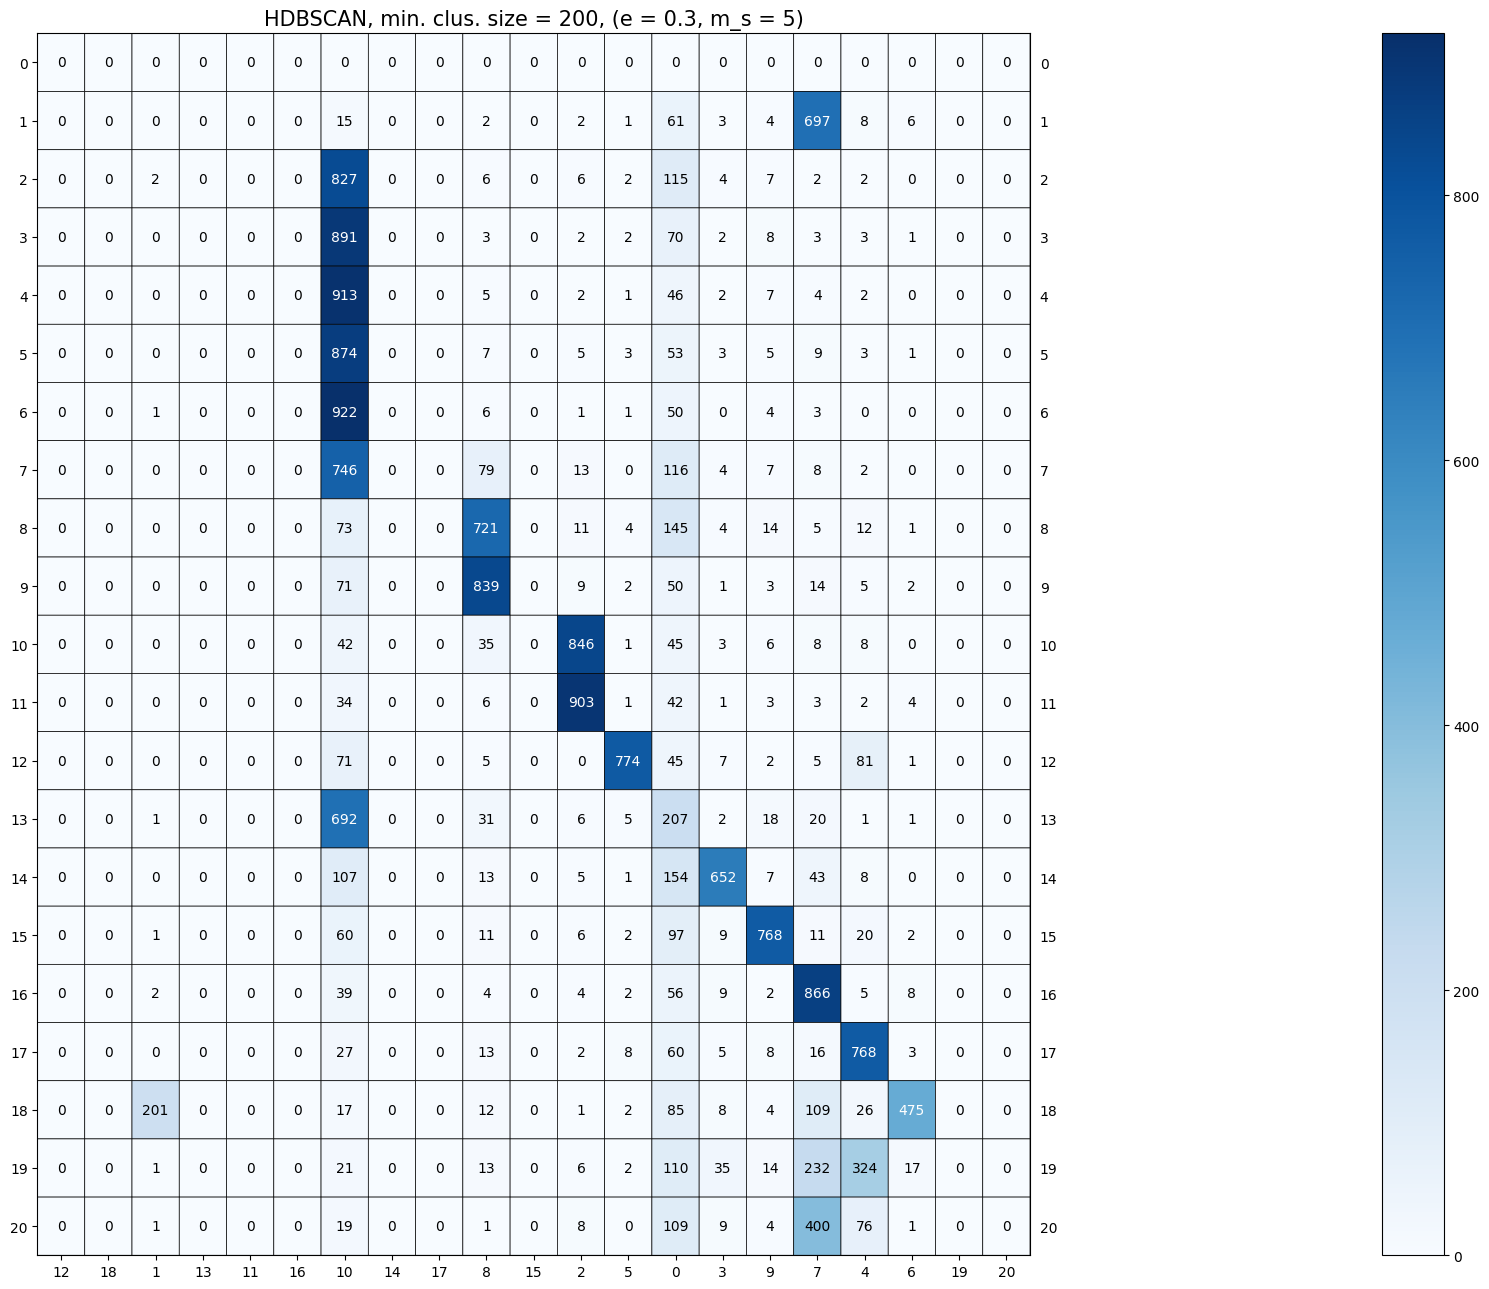

In [11]:
hdbs = hdbscan.HDBSCAN(min_cluster_size=best_minCluster_hdb,cluster_selection_epsilon=best_eps_hdb,min_samples=best_minSample_hdb,core_dist_n_jobs=-1).fit_predict(Umap_cos)
cm = confusion_matrix(dataset.target, hdbs)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'HDBSCAN, min. clus. size = 200, (e = 0.3, m_s = 5)', size=(15,13),pic_fname = 'Q16.png')

# Question 17

### We report the best choice of Dimensionality Reduction and Clustering below and also the Top 5 choices.
### We can see that UMAP(n_components = 20, metric = 'cosine', random_state=0) followed by KMeans(n_clusters=20, random_state=0, init='k-means++', max_iter=5000, n_init=200) is the best combination. We decide the best combination based on the average score of the 5 clustering metrics.

In [15]:
import numpy as np
import scipy.sparse as sp
import umap
import hdbscan
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    homogeneity_score, completeness_score, v_measure_score,
    adjusted_rand_score, adjusted_mutual_info_score
)


dim_reductions = [
    ("None", None),
    ("SVD5", TruncatedSVD(n_components=5, random_state=0)),
    ("SVD20", TruncatedSVD(n_components=20, random_state=0)),
    ("SVD200", TruncatedSVD(n_components=200, random_state=0)),
    ("NMF5", NMF(n_components=5, random_state=0, init='random', max_iter=400)),
    ("NMF20", NMF(n_components=20, random_state=0, init='random', max_iter=400)),
    ("NMF200", NMF(n_components=200, random_state=0, init='random', max_iter=400)),
    ("UMAP5", umap.UMAP(n_components=5, metric="cosine", random_state=0)),
    ("UMAP20", umap.UMAP(n_components=20, metric="cosine", random_state=0)),
    ("UMAP200", umap.UMAP(n_components=200, metric="cosine", random_state=0))
]

clusterings = [
    ("KMeans10",
        KMeans(
            n_clusters=10, random_state=0, init='k-means++',
            max_iter=5000, n_init=200
        )
    ),
    ("KMeans20",
        KMeans(
            n_clusters=20, random_state=0, init='k-means++',
            max_iter=5000, n_init=200
        )
    ),
    ("KMeans50",
        KMeans(
            n_clusters=50, random_state=0, init='k-means++',
            max_iter=5000, n_init=200
        )
    ),
    ("Agglo20",
        AgglomerativeClustering(
            n_clusters=20, linkage='ward'
        )
    ),
    ("HDBSCAN100",
        hdbscan.HDBSCAN(
            cluster_selection_epsilon=best_eps_hdb,
            min_samples=best_minSample_hdb,
            min_cluster_size=100,
            core_dist_n_jobs=-1
        )
    ),
    ("HDBSCAN200",
        hdbscan.HDBSCAN(
            cluster_selection_epsilon=best_eps_hdb,
            min_samples=best_minSample_hdb,
            min_cluster_size=200,
            core_dist_n_jobs=-1
        )
    )
]

dim_outputs = {}

print("Fitting all dimensionality reductions (if any)...")
for dim_name, dim_method in tqdm(dim_reductions, desc="DimRed"):
    if dim_method is None:
        X_transformed = features_all  
    else:
        if isinstance(dim_method, NMF) and sp.issparse(features_all):
            X_transformed = dim_method.fit_transform(features_all.toarray())
        else:
            X_transformed = dim_method.fit_transform(features_all)
    dim_outputs[dim_name] = X_transformed


results = []
best_score = -1.0
best_combo = None
best_metrics = None

all_combos = [(dn, cn) for dn, _ in dim_reductions for cn, _ in clusterings]

print("Running clustering for each DimRed + Clustering combo...")
for (dim_name, cluster_name) in tqdm(all_combos, desc="Clustering", leave=True):
    
    X_transformed = dim_outputs[dim_name]
    
    
    clusterer = next(c for (cn, c) in clusterings if cn == cluster_name)
    
    if sp.issparse(X_transformed) and ("Agglo" in cluster_name):
        X_for_clustering = X_transformed.toarray()
    else:
        X_for_clustering = X_transformed

    labels = clusterer.fit_predict(X_for_clustering)

    h = homogeneity_score(dataset.target, labels)
    c = completeness_score(dataset.target, labels)
    v = v_measure_score(dataset.target, labels)
    ari = adjusted_rand_score(dataset.target, labels)
    ami = adjusted_mutual_info_score(dataset.target, labels)

    avg_5 = (h + c + v + ari + ami) / 5.0
    results.append((dim_name, cluster_name, h, c, v, ari, ami, avg_5))

    # Track best so far
    if avg_5 > best_score:
        best_score = avg_5
        best_combo = (dim_name, cluster_name)
        best_metrics = (h, c, v, ari, ami)


print("==================================================")
print("BEST COMBINATION FOUND:")
print(f"Dimensionality Reduction: {best_combo[0]}")
print(f"Clustering Method:        {best_combo[1]}")
print(f"Avg of 5 metrics:         {best_score:.4f}")
print("Individual Metrics:")
print(f"  Homogeneity:  {best_metrics[0]:.4f}")
print(f"  Completeness: {best_metrics[1]:.4f}")
print(f"  V-measure:    {best_metrics[2]:.4f}")
print(f"  Adj. Rand:    {best_metrics[3]:.4f}")
print(f"  Adj. MI:      {best_metrics[4]:.4f}")
print("==================================================")


results_sorted = sorted(results, key=lambda x: x[-1], reverse=True)
print("Top 5 combinations by average of 5 metrics:")
for i in range(min(5, len(results_sorted))):
    dn, cn, hh, cc, vv, rr, mm, avg = results_sorted[i]
    print(f"{i+1}) {dn} + {cn} => avg={avg:.4f} "
          f"(h={hh:.3f}, c={cc:.3f}, v={vv:.3f}, ARI={rr:.3f}, AMI={mm:.3f})")


Fitting all dimensionality reductions (if any)...


DimRed: 100%|██████████| 10/10 [44:34<00:00, 267.46s/it]


Running clustering for each DimRed + Clustering combo...


Clustering: 100%|██████████| 60/60 [2:01:57<00:00, 121.96s/it]   

BEST COMBINATION FOUND:
Dimensionality Reduction: UMAP20
Clustering Method:        KMeans20
Avg of 5 metrics:         0.5552
Individual Metrics:
  Homogeneity:  0.5704
  Completeness: 0.5919
  V-measure:    0.5809
  Adj. Rand:    0.4533
  Adj. MI:      0.5796
Top 5 combinations by average of 5 metrics:
1) UMAP20 + KMeans20 => avg=0.5552 (h=0.570, c=0.592, v=0.581, ARI=0.453, AMI=0.580)
2) UMAP200 + KMeans20 => avg=0.5551 (h=0.570, c=0.592, v=0.581, ARI=0.453, AMI=0.579)
3) UMAP5 + KMeans20 => avg=0.5529 (h=0.568, c=0.589, v=0.578, ARI=0.452, AMI=0.577)
4) UMAP20 + Agglo20 => avg=0.5494 (h=0.563, c=0.594, v=0.578, ARI=0.435, AMI=0.577)
5) UMAP200 + Agglo20 => avg=0.5312 (h=0.546, c=0.577, v=0.561, ARI=0.412, AMI=0.560)


# Question 18


### Extra Credit:
### We already know that "UMAP (n_components=20) + KMeans(k=20)" gave us a 0.5552 average score across 5 metrics. Below is a script exploring additional UMAP parameters (n_neighbors, min_dist) to see if we can surpass 0.552. 

### From the results below, we observe that using n_neighbours = 30 and min_dist = 0.5, **IMPROVES** our average score (of the 5 clustering metrics) from 0.552 to 0.5908 and also **IMPROVES** upon each individual metric from the 5 clustering metrics. 


### A description of these parameters from the [UMAP documentation](https://umap-learn.readthedocs.io/en/latest/parameters.html) is provided below:


### **n_neighbours**: This parameter controls how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. This means that low values of n_neighbors will force UMAP to concentrate on very local structure (potentially to the detriment of the big picture), while large values will push UMAP to look at larger neighborhoods of each point when estimating the manifold structure of the data, losing fine detail structure for the sake of getting the broader of the data

### The **min_dist** parameter controls how tightly UMAP is allowed to pack points together. It, quite literally, provides the minimum distance apart that points are allowed to be in the low dimensional representation. This means that low values of min_dist will result in clumpier embeddings. This can be useful if you are interested in clustering, or in finer topological structure. Larger values of min_dist will prevent UMAP from packing points together and will focus on the preservation of the broad topological structure instead.

In [16]:
import numpy as np
import umap
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import (
    homogeneity_score, completeness_score, v_measure_score,
    adjusted_rand_score, adjusted_mutual_info_score
)


n_neighbors_list = [2, 5, 15, 30, 50]     # Neighborhood sizes
min_dist_list    = [0.0, 0.01, 0.1, 0.5]  # Controls how tightly UMAP packs points
n_components     = 20                    
metric_used      = "cosine"              


kmeans_config = {
    "n_clusters": 20,
    "random_state": 0,
    "init": "k-means++",
    "max_iter": 5000,
    "n_init": 200
}


best_avg = -1.0
best_params = None
best_metrics = None


for nn in tqdm(n_neighbors_list, desc="n_neighbors"):
    for md in tqdm(min_dist_list, desc=f"min_dist(nn={nn})", leave=False):
        
        reducer = umap.UMAP(
            n_components=n_components,
            n_neighbors=nn,
            min_dist=md,
            metric=metric_used,
            random_state=0
        )
        
        X_umap = reducer.fit_transform(features_all)
        
        km = KMeans(**kmeans_config)
        labels = km.fit_predict(X_umap)
        
        h = homogeneity_score(dataset.target, labels)
        c = completeness_score(dataset.target, labels)
        v = v_measure_score(dataset.target, labels)
        ari = adjusted_rand_score(dataset.target, labels)
        ami = adjusted_mutual_info_score(dataset.target, labels)
        
        avg_5 = (h + c + v + ari + ami) / 5.0
        
        if avg_5 > best_avg:
            best_avg = avg_5
            best_params = (nn, md)
            best_metrics = (h, c, v, ari, ami)

print("==================================================")
print("Extra Credit: Searching UMAP hyperparams to exceed average=0.552")
print(f"BEST AVERAGE METRIC = {best_avg:.4f}  (target > 0.552)")
if best_params is not None:
    print(f"  Best n_neighbors   = {best_params[0]}")
    print(f"  Best min_dist      = {best_params[1]}")
    print("Individual Metrics:")
    print(f"  Homogeneity:       {best_metrics[0]:.4f}")
    print(f"  Completeness:      {best_metrics[1]:.4f}")
    print(f"  V-measure:         {best_metrics[2]:.4f}")
    print(f"  Adj. Rand:         {best_metrics[3]:.4f}")
    print(f"  Adj. MI:           {best_metrics[4]:.4f}")
print("==================================================")



n_neighbors: 100%|██████████| 5/5 [47:01<00:00, 564.35s/it]

Extra Credit: Searching UMAP hyperparams to exceed average=0.552
BEST AVERAGE METRIC = 0.5908  (target > 0.552)
  Best n_neighbors   = 30
  Best min_dist      = 0.5
Individual Metrics:
  Homogeneity:       0.6083
  Completeness:      0.6249
  V-measure:         0.6165
  Adj. Rand:         0.4891
  Adj. MI:           0.6152
